# Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [1]:
sciper = {'student_1': 250090, 
          'student_2': 236849}
seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

import midi
import music21

import copy
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [86]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H_T=None, H_P=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H_T is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H_T[:xlim[1]-1,k], H_T[1:xlim[1],k])] for k in range(H_T.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H_T = H_T[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H_T.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H_T[n]$")
        plt.show()
        
    if H_P is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H_P[:xlim[1]-1,k], H_P[1:xlim[1],k])] for k in range(H_P.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H_P = H_P[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H_P.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H_P[n]$")
        plt.show()


def plotLearningCurves(History, History_1):
    
    log = History.history
    log_1 = History_1.history
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=1, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
np.random.seed(seed)

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4755/45853 melodies retained


### Solution

In [4]:
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    for n, event in enumerate(events):
        #if type(event) == midi.NoteOnEvent or type(event) == midi.NoteOffEvent:
        if type(event) == midi.NoteOffEvent:
            P.append(event.data[0])
            T.append(event.tick)
    return P, T

for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')


sessiontune17389
MIDI events
chorpus/sessiontune17389.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 62 	 Note On 	 105
240 	 62 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 65 	 Note On 	 105
1200 	 65 	 Note Off 	 0
1201 	 69 	 Note On 	 80
1440 	 69 	 Note Off 	 0
1441 	 65 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
112801 	 62 	 Note On 	 105
113040 	 62 	 Note Off 	 0
113041 	 64 	 Note On 	 80
113280 	 64 	 Note Off 	 0
113281 	 62 	 Note On 	 80
114240 	 62 	 Note Off 	 0
114241 	 62 	 Note On 	 105
115680 	 62 	 Note Off 	 0
########################################

Note representation
{'T': [239, 239, 719, 239, 479, 239, 719, 479, 959, 479, 959, 239, 239, 719, 239, 479, 239, 719, 479, 2399, 239, 239, 239, 719, 479, 479, 319, 159, 239, 239, 479, 1919, 239, 119, 119, 479, 239, 239, 239, 119, 119, 479, 719, 239, 2399, 239, 239, 479, 239, 239, 319, 159, 479, 15

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

In [5]:
p_ = []
t_ = []
for x in dataset.keys():
    p_.extend(dataset[x]['P'])
    t_.extend(dataset[x]['T'])
p_= list(set(p_))
t_ = list(set(t_))

In [6]:
p_dict = dict(zip(p_, range(len(p_))))
t_dict =dict(zip(t_, range(len(t_))))

In [7]:
for label in np.random.choice(list(dataset.keys()), 2):
    print('*'*19)
    print(label)
    print('*'*19 + '\n')
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print('*'*19+'\n')
    print(dataset[label])
    print('\n')
    print("Integer representation")
    print('*'*25+'\n')
    p = dataset[label]["P"].copy()
    t = dataset[label]["T"].copy()
    for x_i in range(len(dataset[label]["P"])):
        p[x_i] = p_dict.get(dataset[label]["P"][x_i])
    for x_j in range(len(dataset[label]["T"])):
        t[x_j] = t_dict.get(dataset[label]["T"][x_j])
    a = {"T":t, "P": p}
    print(a)
    print('\n')

*******************
sessiontune32619
*******************

MIDI events
chorpus/sessiontune32619.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 65 	 Note On 	 105
240 	 65 	 Note Off 	 0
241 	 68 	 Note On 	 80
480 	 68 	 Note Off 	 0
481 	 73 	 Note On 	 80
720 	 73 	 Note Off 	 0
721 	 70 	 Note On 	 80
960 	 70 	 Note Off 	 0
961 	 68 	 Note On 	 95
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
45121 	 65 	 Note On 	 95
45360 	 65 	 Note Off 	 0
45361 	 61 	 Note On 	 80
45600 	 61 	 Note Off 	 0
45601 	 61 	 Note On 	 80
45840 	 61 	 Note Off 	 0
45841 	 63 	 Note On 	 80
46080 	 63 	 Note Off 	 0
########################################

Note representation
*******************

{'T': [239, 239, 239, 239, 719, 239, 239, 239, 239, 239, 239, 239, 479, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 239, 719, 239, 239, 239, 239, 239, 239, 239, 479, 239, 239, 239

In [8]:
dataset_integer = copy.deepcopy(dataset)
for label in list(dataset.keys()):
    a = {"P": list(map(lambda x: p_dict.get(x), dataset[label]["P"])),
         "T":list(map(lambda x: t_dict.get(x), dataset[label]["T"]))}
    dataset_integer[label] = a    

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

### Solution

## Rare event suppression

### 1.

In [9]:
durations_values = []
for label in list(dataset.keys()):
    durations_values.extend(dataset[label]["T"])

In [10]:
import operator

In [11]:
# Most common durations
sorted(dict(Counter(durations_values)).items(), key=operator.itemgetter(1), reverse=True)[:10]

[(239, 635049),
 (479, 93853),
 (159, 66340),
 (119, 46929),
 (319, 29953),
 (719, 20144),
 (59, 13040),
 (959, 6381),
 (79, 3044),
 (0, 2174)]

In [12]:
# Some outliers 
outliers = sorted(dict(Counter(durations_values)).items(), key=operator.itemgetter(0), reverse=True)
outliers[:10]

[(5759, 3),
 (3839, 4),
 (3359, 18),
 (3119, 5),
 (2879, 62),
 (2639, 8),
 (2399, 167),
 (2159, 61),
 (2079, 2),
 (2039, 4)]

In [13]:
durations_nb = len(dict(Counter(durations_values)).items())
durations_nb

70

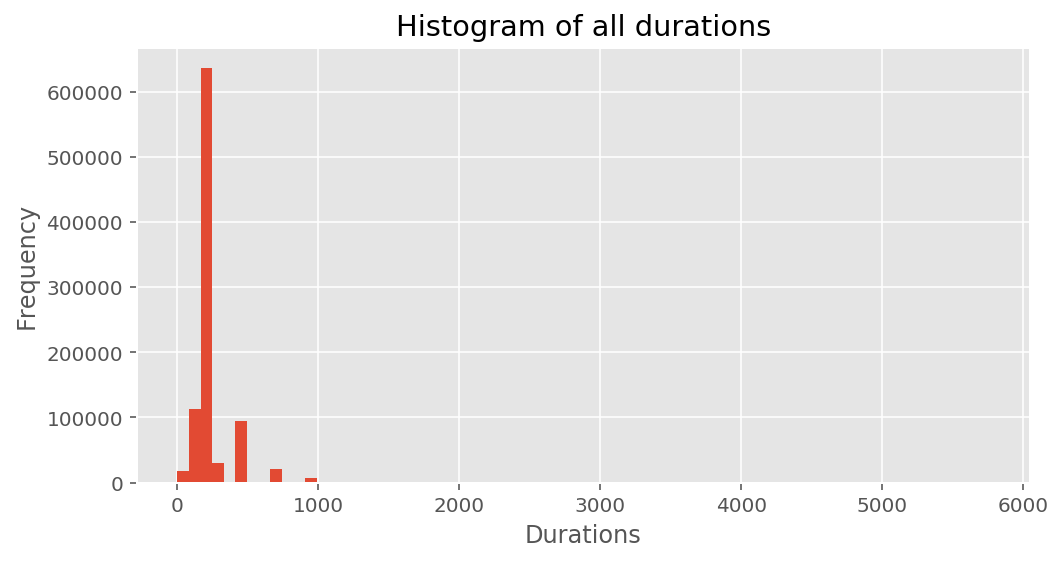

In [14]:
plt.hist(durations_values,bins = len(set(durations_values)))
plt.title('Histogram of all durations')
plt.xlabel('Durations')
plt.ylabel('Frequency')
plt.grid()
plt.show()

**We see from the histogram that the most common durations are between 200 and 700 (printed above), and we can see that there is quite a few outliers (printed above as well) that made the histogram shift to the left. Also, there is a huge gap between the minimum and the maximum values of durations.**

### 2.

In [15]:
len(dataset)

4755

In [16]:
# Five percent of the dataset
len(dataset)/100*5

237.75

**We now filter out the melodies that contains durations greater than 1200 (considered as rare). These latter ones consitute about 5% of the total number of melodies.**

In [17]:
nb_melo_del = 0
for label in list(dataset.keys()):
    if len(list(filter(lambda x: x> 1200, dataset[label]["T"]))) > 0:
        del dataset[label]
        nb_melo_del += 1

In [18]:
# Number of melodies filtered out
nb_melo_del

329

In [19]:
# Lenght of the filtered dataset
len(dataset)

4426

### 3.

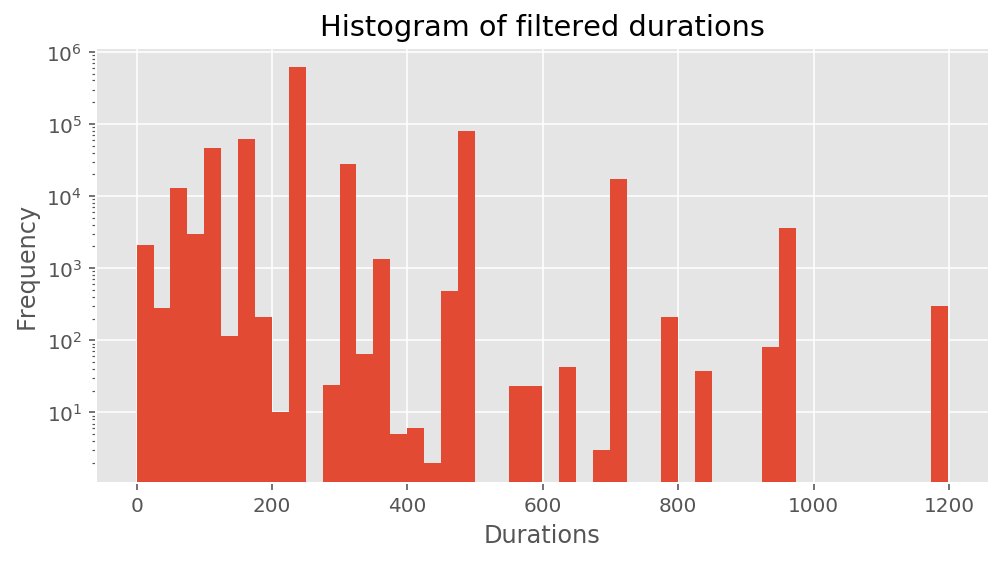

In [20]:
# Recompute the filtered duration dictionary 
durations_values = []
for label in list(dataset.keys()):
    durations_values.extend(dataset[label]["T"])

#Plot the new histogram of durations
plt.hist(durations_values,bins = len(set(durations_values)), log=True)
plt.title('Histogram of filtered durations')
plt.xlabel('Durations')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [21]:
filtered_durations_nb = len(dict(Counter(durations_values)).items())
filtered_durations_nb

48

In [22]:
print('The range of possible values decreased from {} to {}'\
      .format(durations_nb, filtered_durations_nb))

The range of possible values decreased from 70 to 48


## Pitch normalization

### 1.

In [23]:
# Create a dataset with the integer representation of all pitches and ticks
dataset_integer = copy.deepcopy(dataset)
for label in list(dataset.keys()):
    a = {"P": list(map(lambda x: p_dict.get(x), dataset[label]["P"])),
         "T":list(map(lambda x: t_dict.get(x), dataset[label]["T"]))}
    dataset_integer[label] = a 

In [24]:
def transposeDataset(dataset):
    transposed_dataset = {}

    for label in list(dataset.keys()):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

**Now we use the provided function to create a new dataset where all melodies are transposed to C Major/A minor.**

In [25]:
transposed_dataset = transposeDataset(dataset)

### 2.

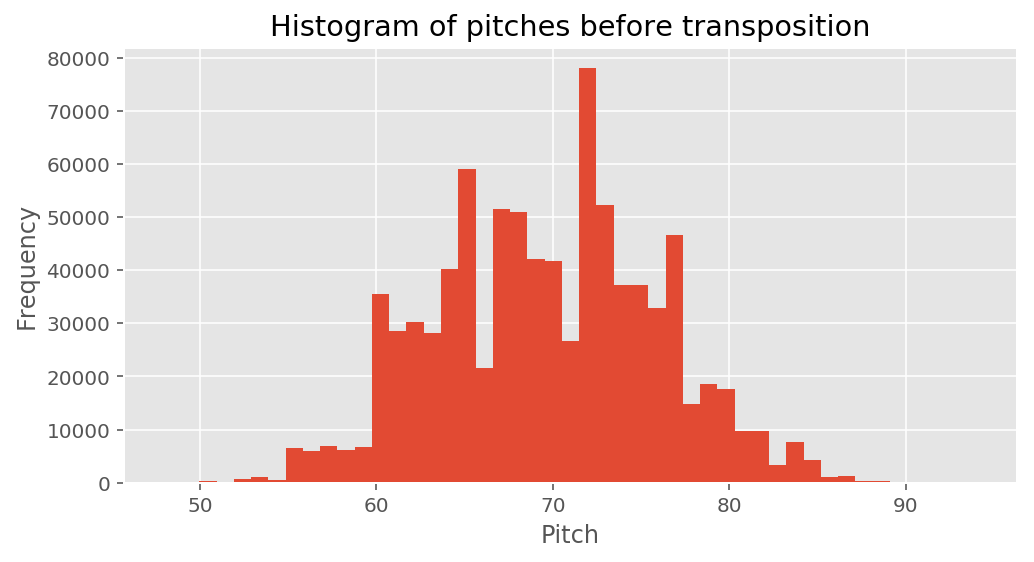

In [26]:
pitches = []
for label in list(dataset.keys()):
    pitches.extend(dataset[label]["P"])
plt.hist(pitches,bins = len(set(pitches)))
plt.xlabel('Pitch')
plt.ylabel('Frequency')
plt.title('Histogram of pitches before transposition')
plt.grid()
plt.show()

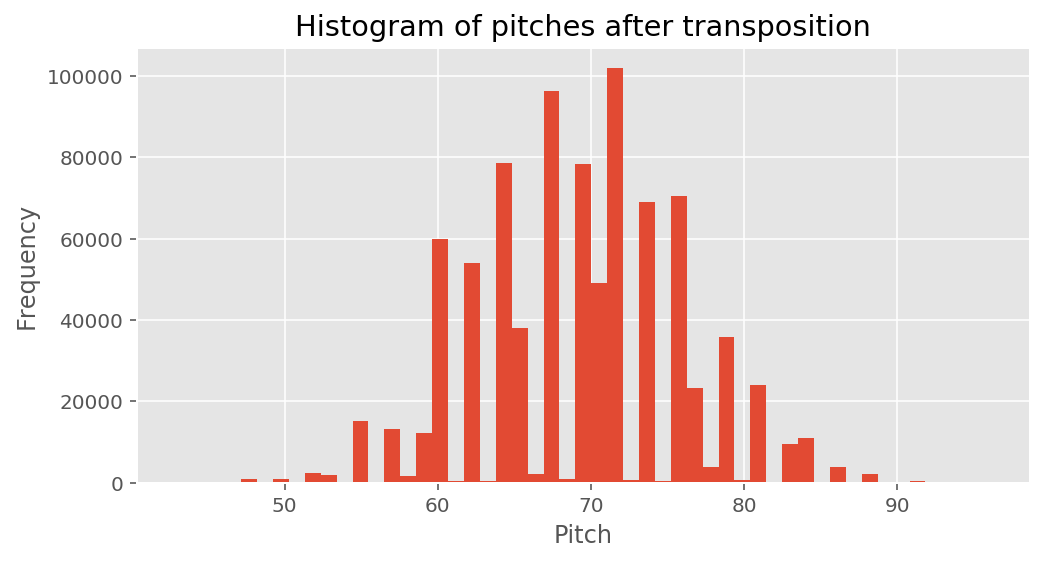

In [27]:
pitches = []
for label in list(transposed_dataset.keys()):
    pitches.extend(transposed_dataset[label]["P"])
plt.hist(pitches,bins = len(set(pitches)))
plt.xlabel('Pitch')
plt.ylabel('Frequency')
plt.title('Histogram of pitches after transposition')
plt.grid()
plt.show()

In [28]:
p_ = []
t_ = []
for x in transposed_dataset.keys():
    p_.extend(transposed_dataset[x]['P'])
    t_.extend(transposed_dataset[x]['T'])
p_= list(set(p_))
t_ = list(set(t_))

In [29]:
p_dict = dict(zip(p_, range(len(p_))))
t_dict =dict(zip(t_, range(len(t_))))

In [30]:
transposed_dataset_integer = copy.deepcopy(transposed_dataset)
for label in list(dataset.keys()):
    a = {"P": list(map(lambda x: p_dict.get(x), transposed_dataset[label]["P"])),
         "T": list(map(lambda x: t_dict.get(x), transposed_dataset[label]["T"]))}
    transposed_dataset_integer[label] = a 

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: The space of possible durations decreased from 70 to 48 after the rare suppression event. This will obvisouly speed up a lot the training process since there is less durations for the network to consider, hence less neurons and less connections to 'keep track of'.

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**: One same melody can be played in several possible tonalities (or keys, split into minor and major keys), and they all should implicitly be perceived by the neural net as a 'single' melody when predicting, and that's what it's meant by invariance. Since there is a lot of possible keys, it is practically unfeasible to apply them all to every single melody of the dataset, we therefore add the transposition of each tonality into C major or A minor, depending whether the original tonality of major or minor respectively, since these 2 tonalities are the most common, hoping to get a better accuracy for the prediction.

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: Keeping a joint representations would yield to much more possible duration/pitch combinations, since the network will learn to predict on a jointly fashion. Hence this will induce an implicit dependency between the each duration/pitch features, and the prediction will be hard. On the other hand, separating the two gives more flexibility to the network to figure out the 'right' duration/pitch combinations on its own, and it seems more appropriate to do so.

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: The distribution of the joint reprensentation would be more flattened compared to the separate distributions, i.e. more pitch/duration combinations with less frequencies.

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

## 1. One hot encode

In [31]:
inv_p_dict = {v: k for k, v in p_dict.items()}
inv_t_dict = {v: k for k, v in t_dict.items()}

In [32]:
ohzp_dataset = {}
for label in list(transposed_dataset_integer.keys()):
    ohzp_dataset[label] = {"P": keras.utils.to_categorical(transposed_dataset_integer[label]["P"], len(p_dict)),
                          "T": keras.utils.to_categorical(transposed_dataset_integer[label]["T"], len(t_dict))}

BEFORE ONE HOT CODING


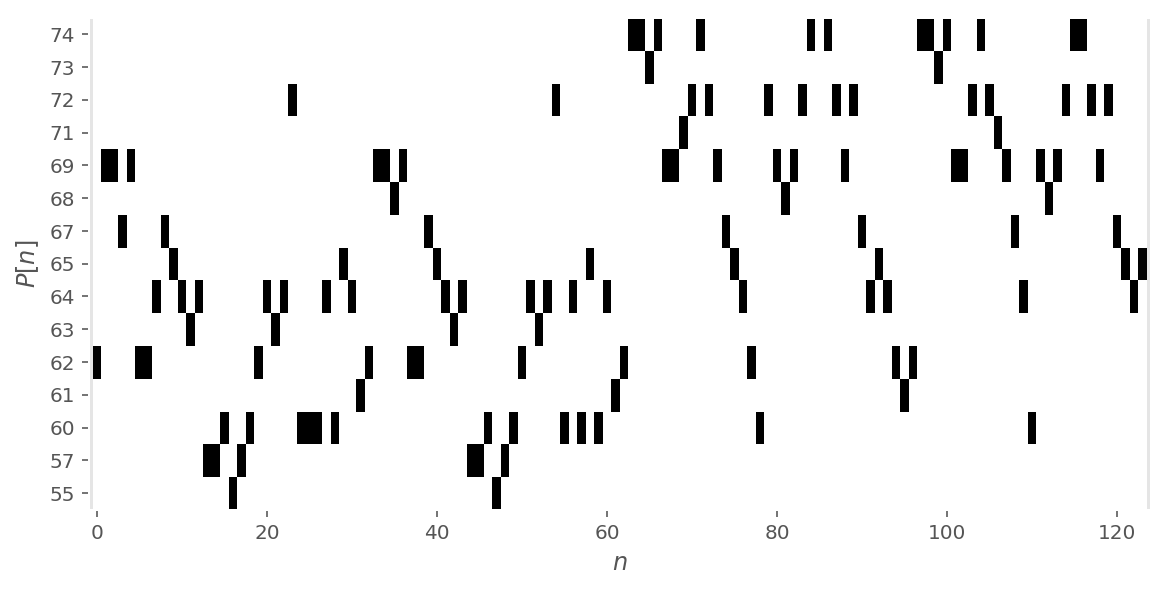

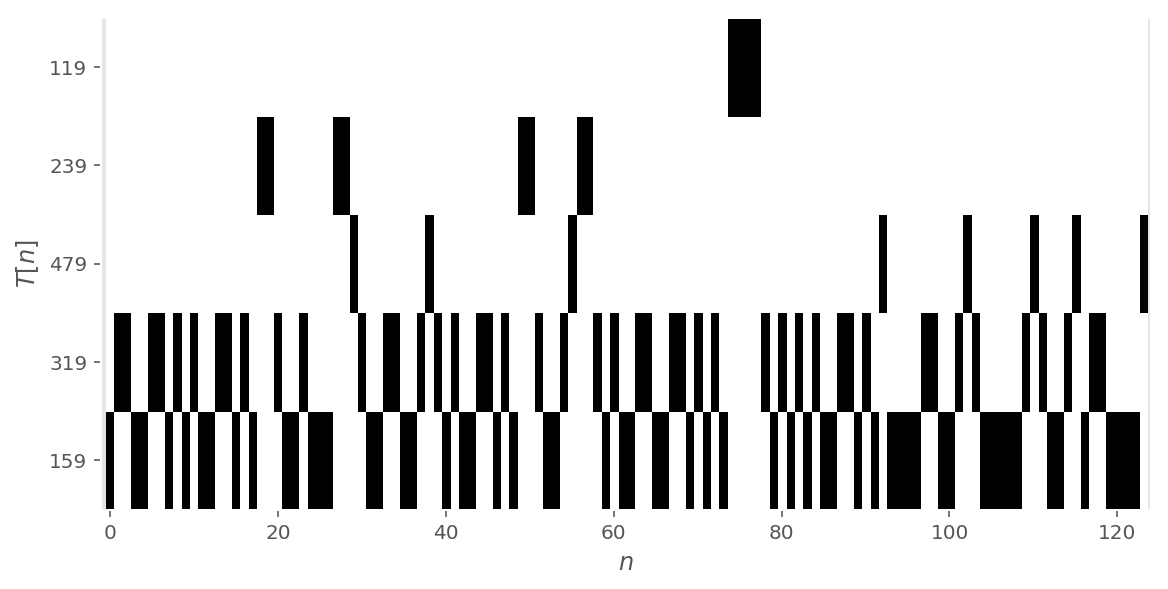

AFTER ONE HOT CODING


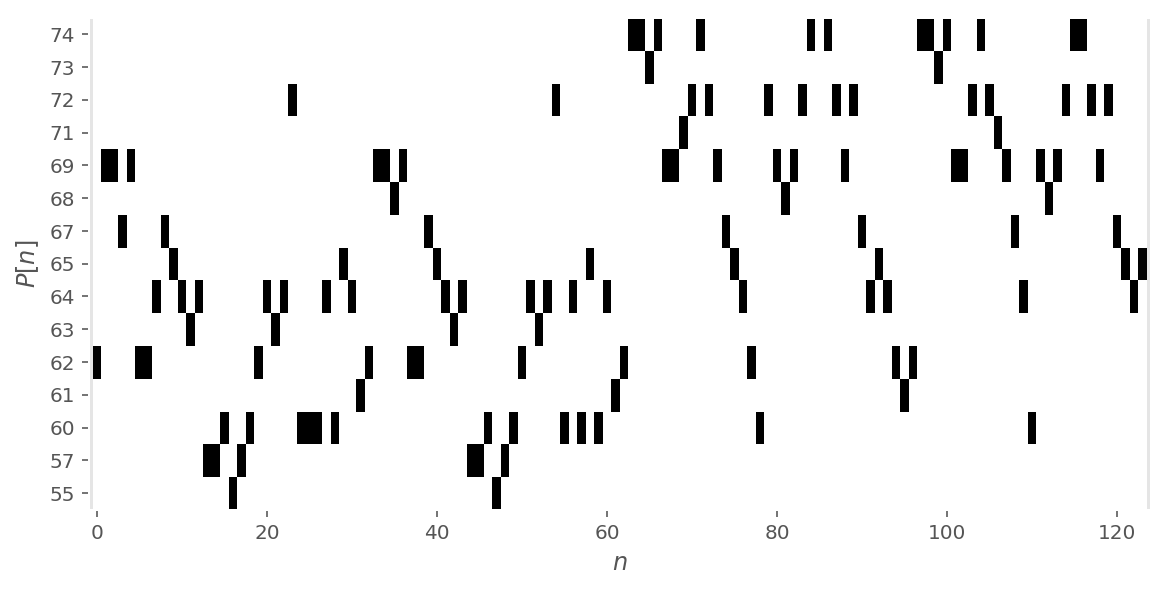

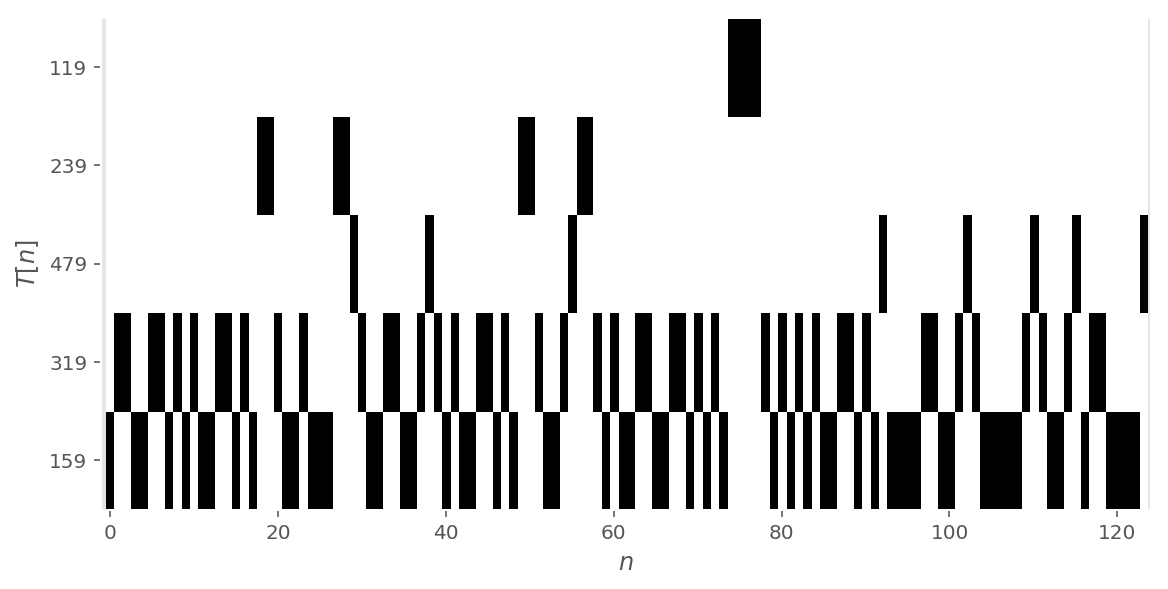

BEFORE ONE HOT CODING


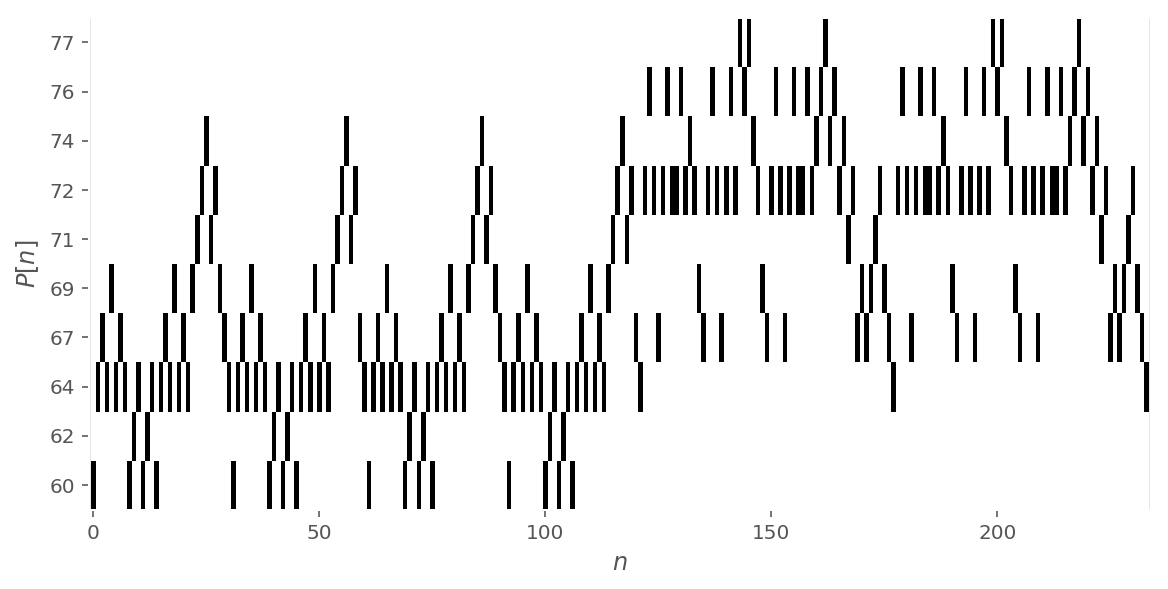

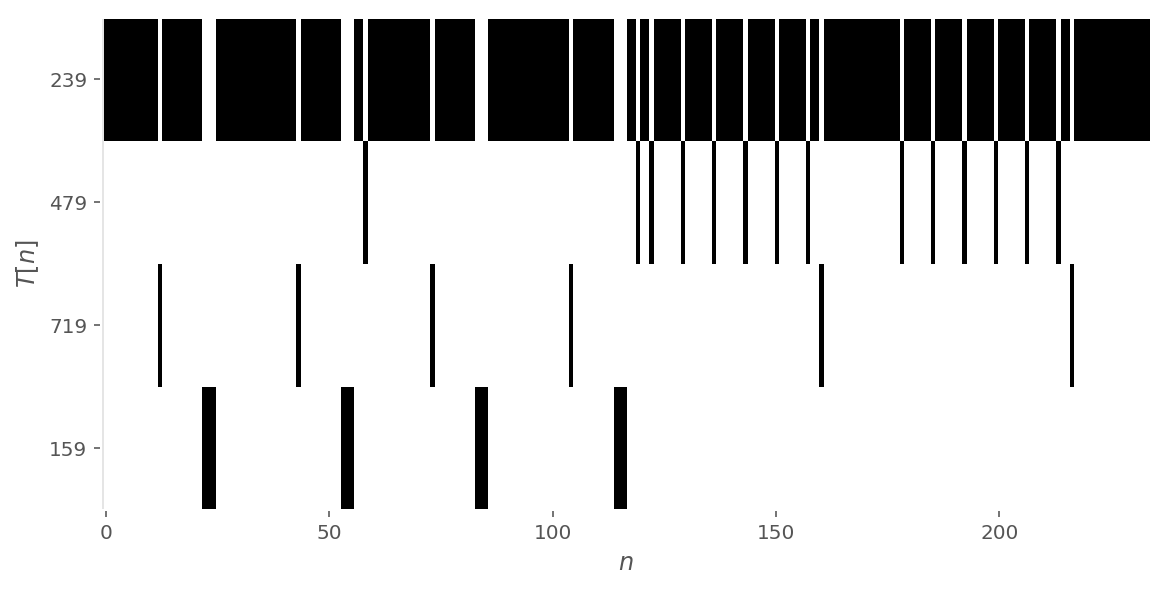

AFTER ONE HOT CODING


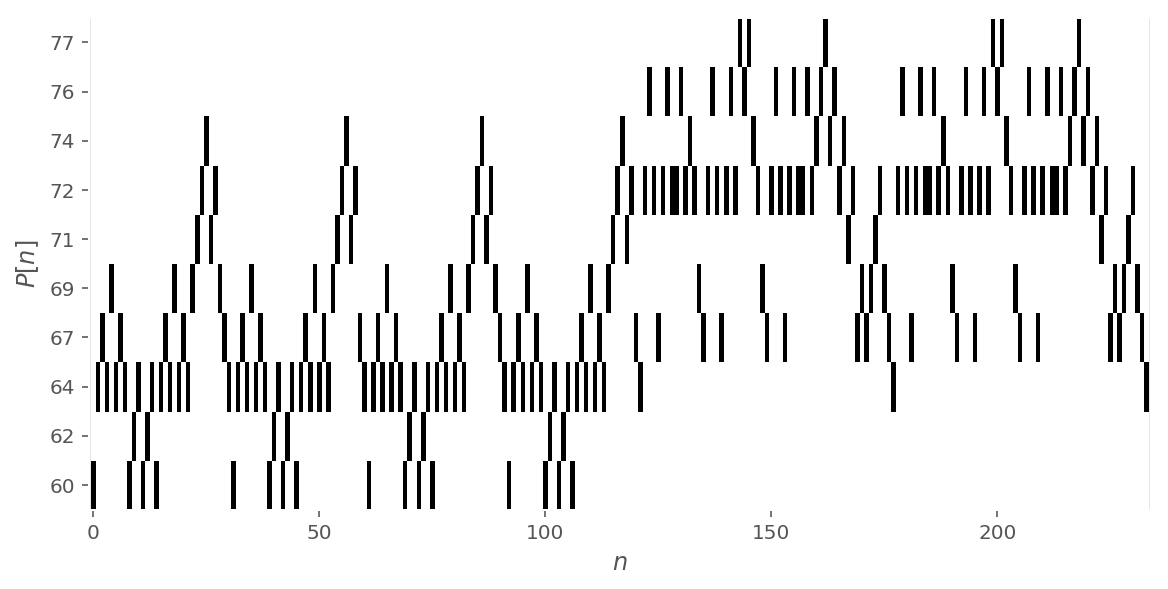

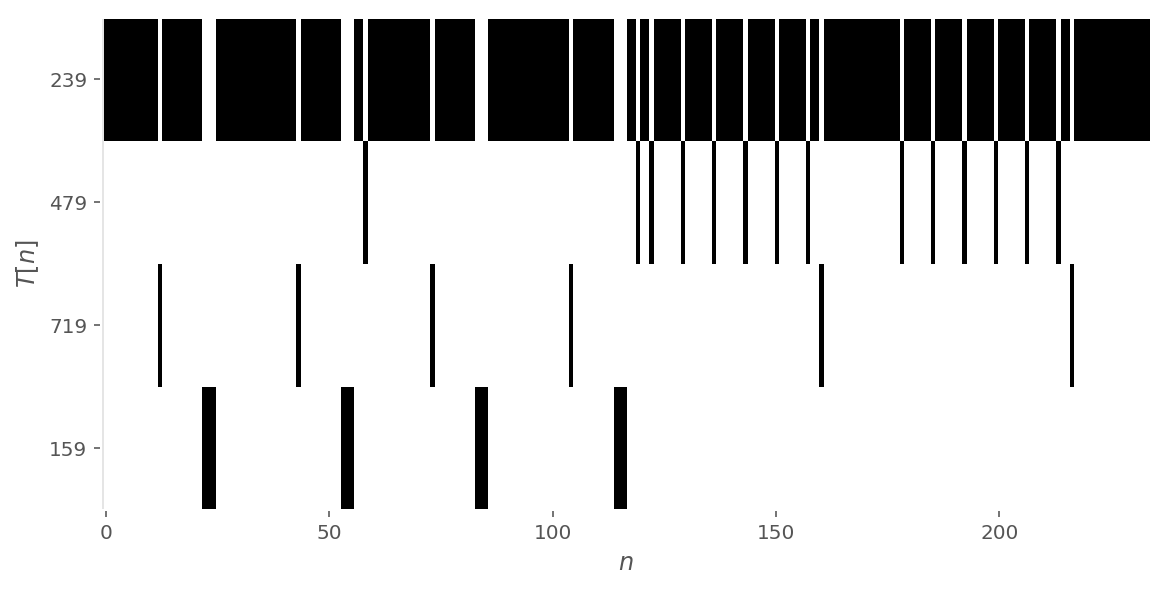

In [33]:
for label in np.random.choice(list(transposed_dataset_integer.keys()), 2):
    print("BEFORE ONE HOT CODING")
    plotMelody(transposed_dataset_integer[label]["P"],transposed_dataset_integer[label]["T"],{"P": inv_p_dict, "T": inv_t_dict})
    print("AFTER ONE HOT CODING")
    plotMelody(ohzp_dataset[label]["P"], ohzp_dataset[label]["T"], {"P": inv_p_dict, "T": inv_t_dict})

## Zero-padding

### 1.

In [34]:
p_lengths = []
num_melodies = len(ohzp_dataset)
for melody in dataset:
    p_lengths.append(len(ohzp_dataset[melody]['P']))

p_lengths = np.asarray(p_lengths)
maxlen = int(p_lengths.mean() + 2* p_lengths.std())
XP = np.array([ohzp_dataset[k]['P'] for k in ohzp_dataset])
XT = np.array([ohzp_dataset[k]['T'] for k in ohzp_dataset])   

P_padded = pad_sequences(XP, maxlen=maxlen, padding='post')
T_padded = pad_sequences(XT, maxlen=maxlen, padding='post')  

In [35]:
YP = np.array([mel[1:] for mel in P_padded])
YT = np.array([mel[1:] for mel in T_padded])
XP = np.array([mel[:-1] for mel in P_padded])
XT = np.array([mel[:-1] for mel in T_padded])

### 2.

In [36]:
print(YP.shape)
print(YT.shape)
print(XP.shape)
print(XT.shape)

(4426, 398, 51)
(4426, 398, 48)
(4426, 398, 51)
(4426, 398, 48)


In [37]:
dictionaries = {'P': range(XP.shape[2]), "T": range(XT.shape[2])}

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [38]:
def buildModel(dictionaries, batch_length, dropout=0.2, activation='GRU', Hsize=128):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    X['T'] = Input(shape=(batch_length, len(dictionaries['T'])), name="XT")
    X['P'] = Input(shape=(batch_length, len(dictionaries['P'])), name="XP")
    
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    if activation == 'GRU':
        H['T'] = GRU(units=128, return_sequences=True, dropout=dropout)(H['1'])
        H['P'] = GRU(units=128, return_sequences=True, dropout=dropout)(H['1'])
        #Your hidden layer(s) architecture with GRU
    elif activation == 'LSTM':
        a = 0
        #Your hidden layer(s) architecture with LSTM (For your own curiosity, not required for the project)
    elif activation == 'RNN':
        H['T'] = SimpleRNN(units=128, return_sequences=True, dropout=dropout)(H['1'])
        H['P'] = SimpleRNN(units=128, return_sequences=True, dropout=dropout)(H['1']) 
        #Your hidden layer(s) architecture with SimpleRNN

    Y['T'] = TimeDistributed(Dense(len(dictionaries['T']), activation='softmax'), name='YT')(H['T'])#Input(s) to duration output layer)
    Y['P'] = TimeDistributed(Dense(len(dictionaries['P']), activation='softmax'), name='YP')(H['P'])#Input(s) to pitch output layer)
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    model_w_o_output = Model(inputs = [X['T'], X['P']], outputs = [H['T'], H['P']])
    
    models = [model, model_w_o_output]
    
    for m in models:  
        opt = Adam() 
        m.compile(
            loss='categorical_crossentropy', 
            optimizer=opt,
            metrics=['acc'])
    return model, model_w_o_output

RNNmodel, RNNmodel_w_o_output = buildModel(dictionaries, 
                      batch_length=P_padded.shape[1]-1,#Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      dropout = 0.4,
                      activation='RNN')
RNNmodel.summary()
GRUmodel, GRUmodel_w_o_output = buildModel(dictionaries,
                      batch_length=P_padded.shape[1]-1,
                      dropout = 0.4,
                      activation='GRU')
GRUmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 398, 48)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 398, 51)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 398, 48)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 398, 51)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

In [39]:
def split(X, cut):
    X_train = X[:cut]
    X_test = X[cut:]
    return X_train, X_test

cut = int(len(XT)*0.8)
XT_train, XT_test = split(XT, cut)
XP_train, XP_test = split(XP, cut)
YT_train, YT_test = split(YT, cut)
YP_train, YP_test = split(YP, cut)

### 1.

In [40]:
hist = RNNmodel.fit({'XT': XT_train, 'XP': XP_train}, {'YT': YT_train, 'YP': YP_train},validation_data=({'XT': XT_test, 'XP': XP_test}, {'YT': YT_test, 'YP': YP_test})
                    , epochs=250, verbose = 0)

### 2.

In [41]:
hist_gru = GRUmodel.fit({'XT': XT_train, 'XP': XP_train}, {'YT': YT_train, 'YP': YP_train},
                        validation_data=({'XT': XT_test, 'XP': XP_test}, {'YT': YT_test, 'YP': YP_test}),
                        epochs = 250, verbose = 0)

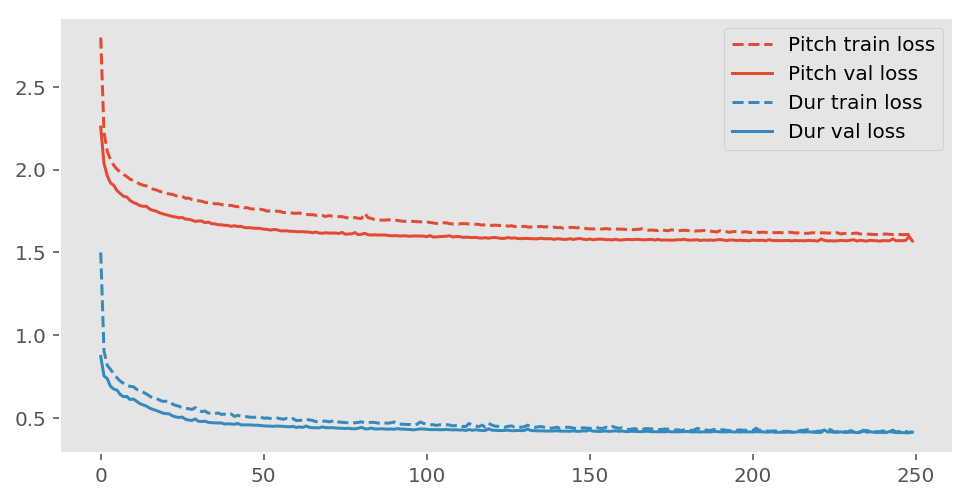

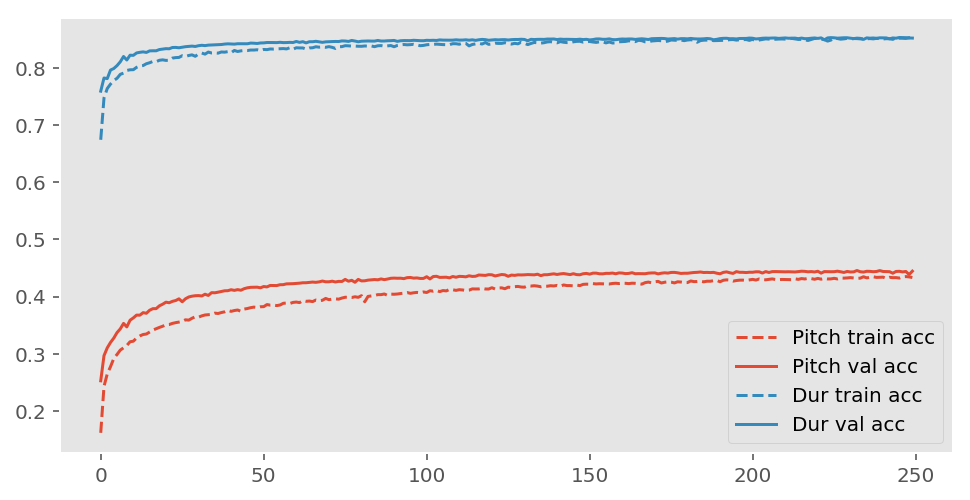

In [42]:
plotLearningCurves(hist_gru)

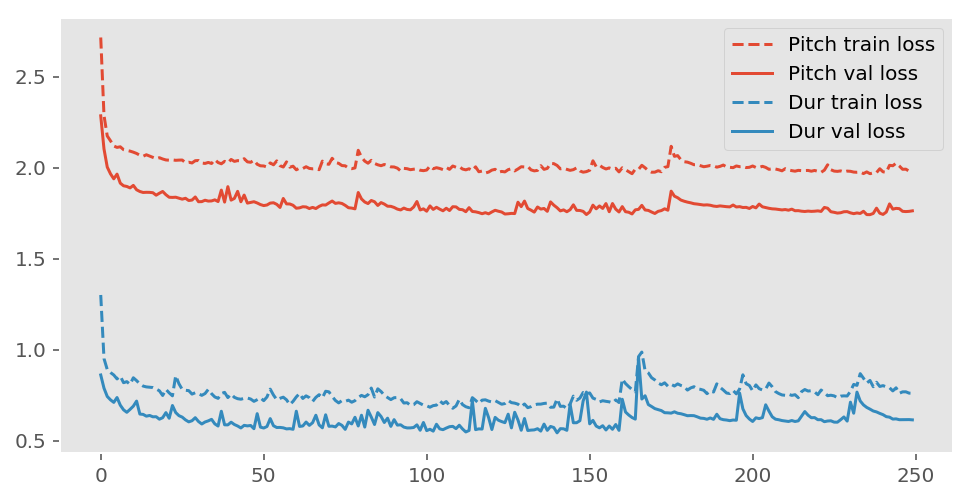

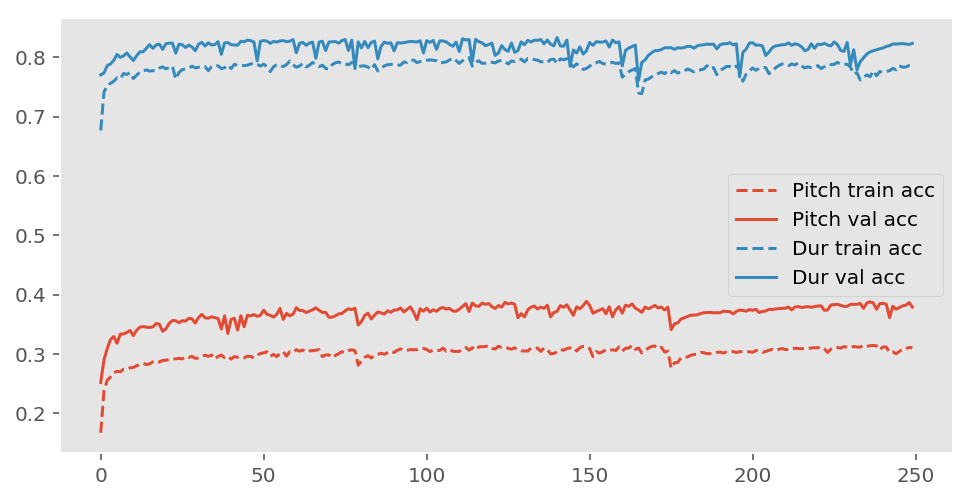

In [43]:
plotLearningCurves(hist)

In [44]:
RNNmodel.evaluate({'XT': XT_test, 'XP': XP_test}, {'YT': YT_test, 'YP': YP_test})

886/886 [==============================] - 4s 4ms/step


[2.3760445198679077,
 0.61364919862144418,
 1.762395316537293,
 0.82335278815663426,
 0.37876126042338043]

In [45]:
GRUmodel.evaluate({'XT': XT_test, 'XP': XP_test}, {'YT': YT_test, 'YP': YP_test})

886/886 [==============================] - 5s 6ms/step


[1.9832549762510554,
 0.41413494769660397,
 1.5691200325236094,
 0.85212341872617836,
 0.44458724709719621]

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: 
The best accuracies are the one obtained by the model with the GRU layers.
Namely after 250 epochs we obtained:
    - Duration validation accuracy: 0.852
    - Pitch validation accuracy: 0.445

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: The learning curves of the model with the GRU layer are much more smooth.



## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

In [71]:
def GRU_sample_acc(XP,XT,YP,YT):
    mel_len = len(XP)
    acc = GRUmodel.evaluate({"XP":XP.reshape((1, mel_len, -1)),
                             "XT": XT.reshape((1, mel_len, -1))},
                            {"YP" :YP.reshape((1, mel_len, -1)),
                             "YT":YT.reshape((1, mel_len, -1))})
    return list(zip(GRUmodel.metrics_names,acc))

In [72]:
rdm_melodies_idx = np.random.choice(range(0,len(XP)),size = 4, replace=False)

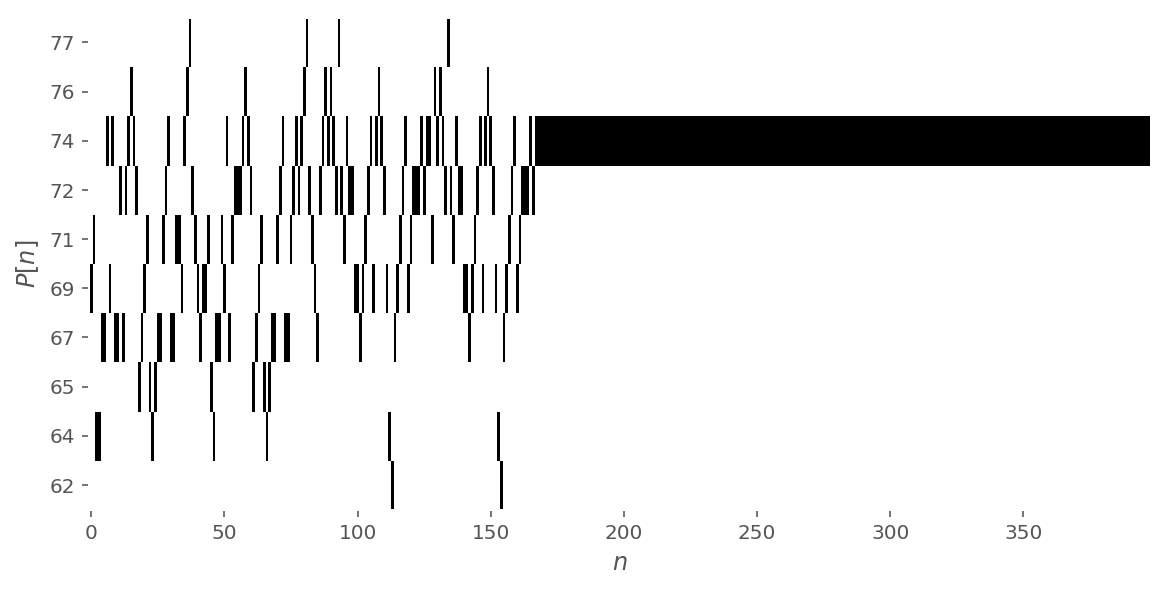

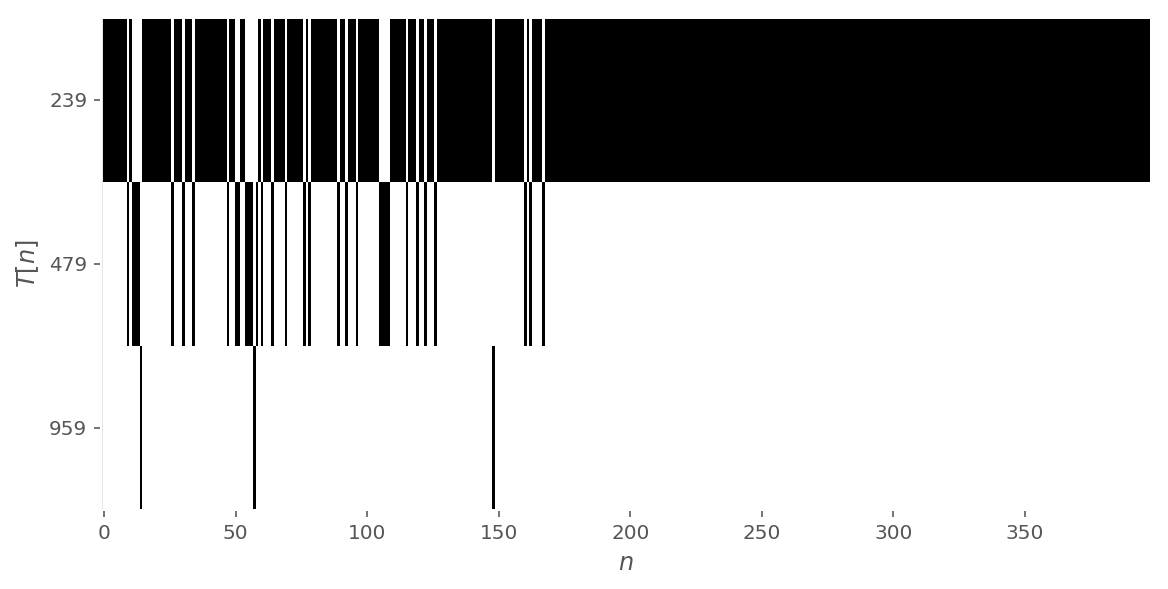

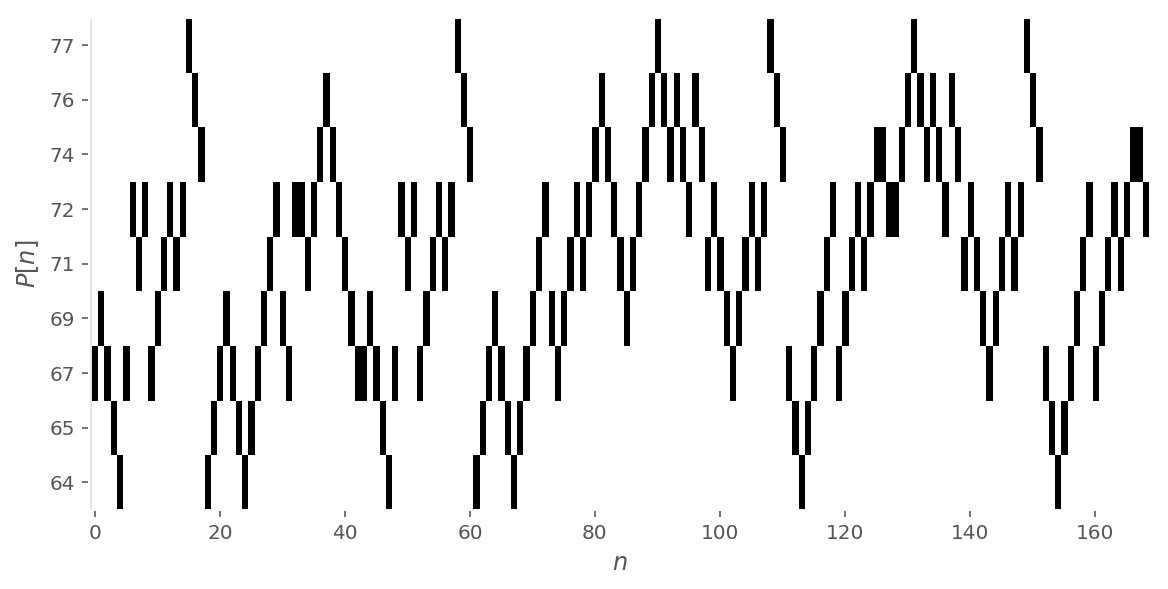

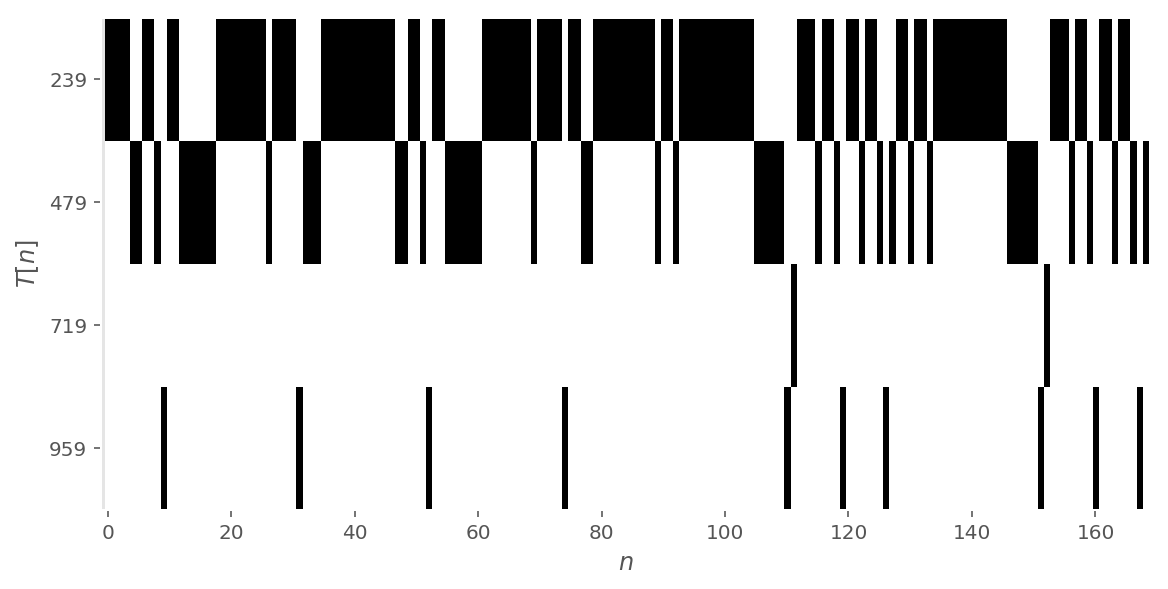

(398, 51) (398, 48) (398, 51) (398, 48)
1/1 [==============================] - 0s 61ms/step
[('loss', 1.8690907955169678), ('YT_loss', 0.70301437377929688), ('YP_loss', 1.1660764217376709), ('YT_acc', 0.65088766813278198), ('YP_acc', 0.59171605110168457)]


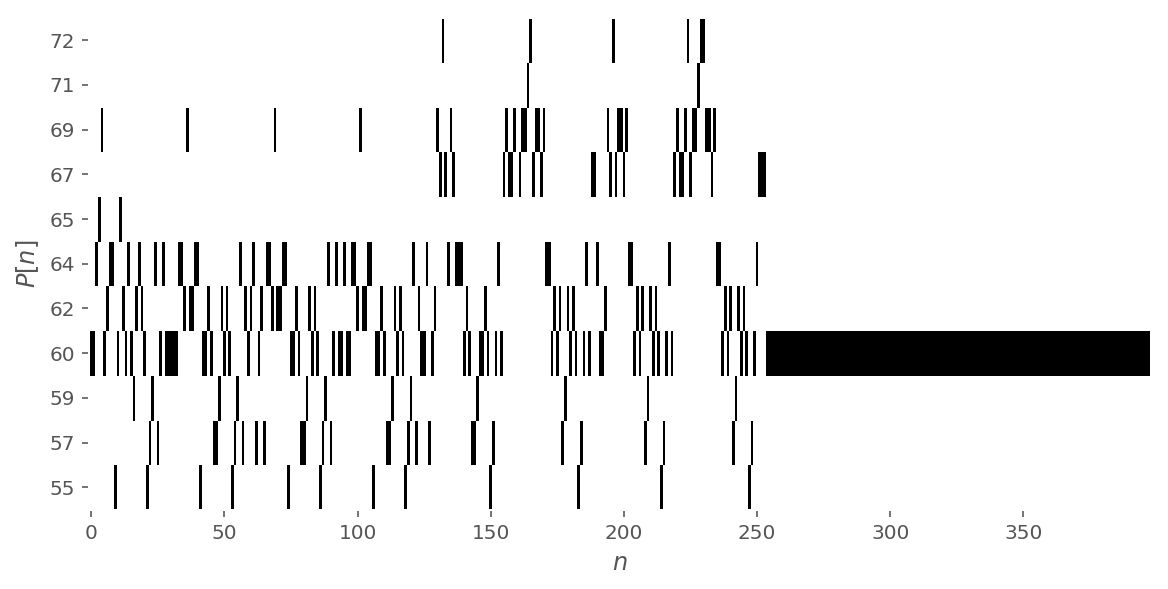

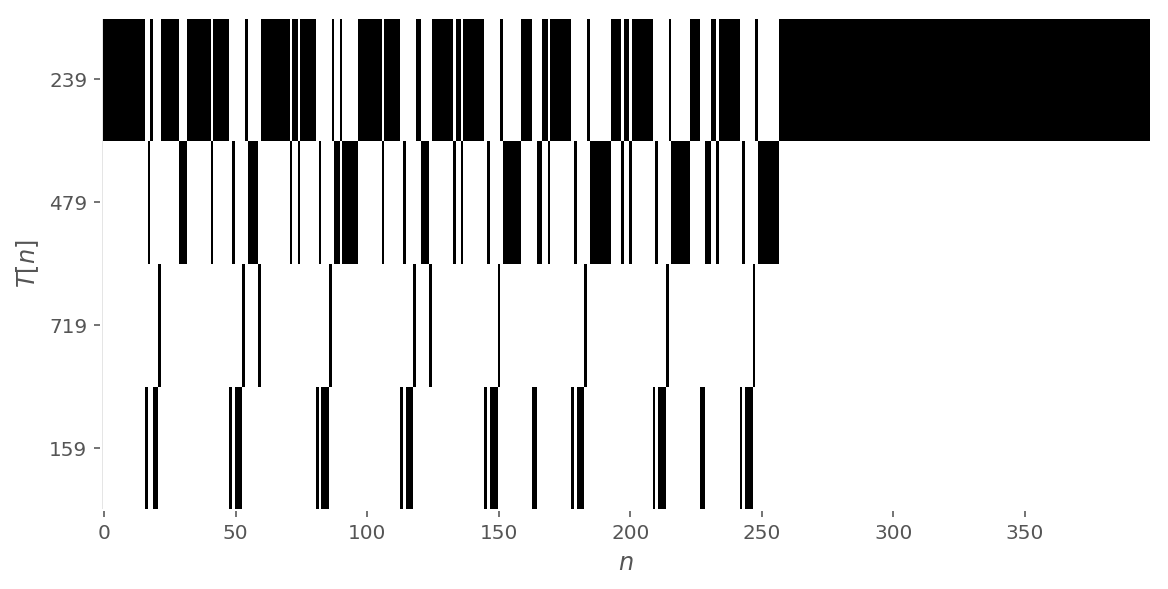

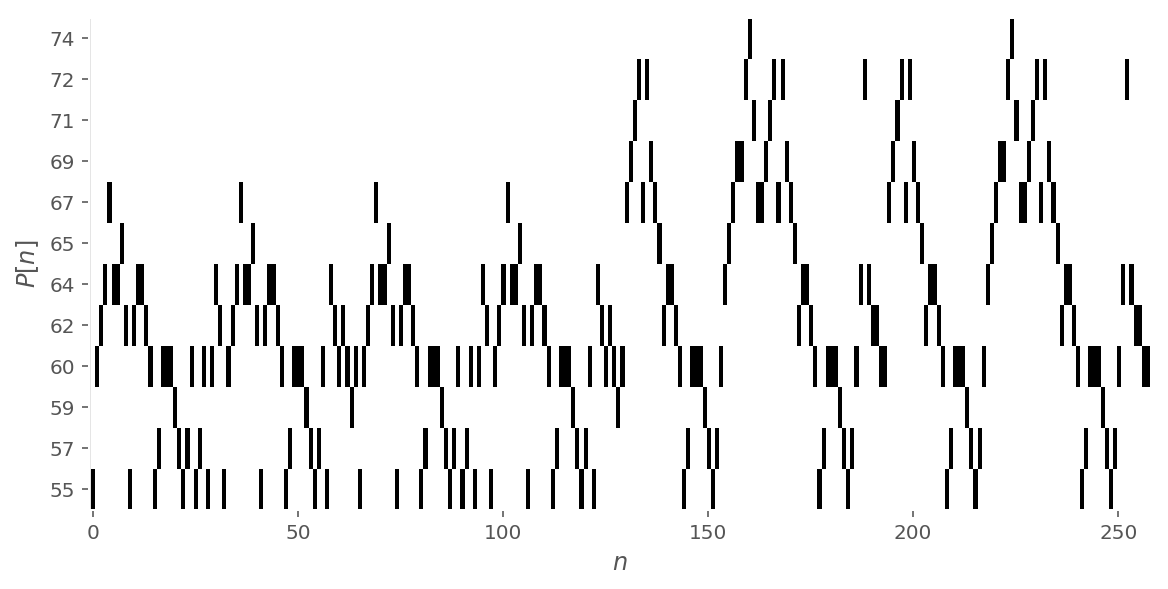

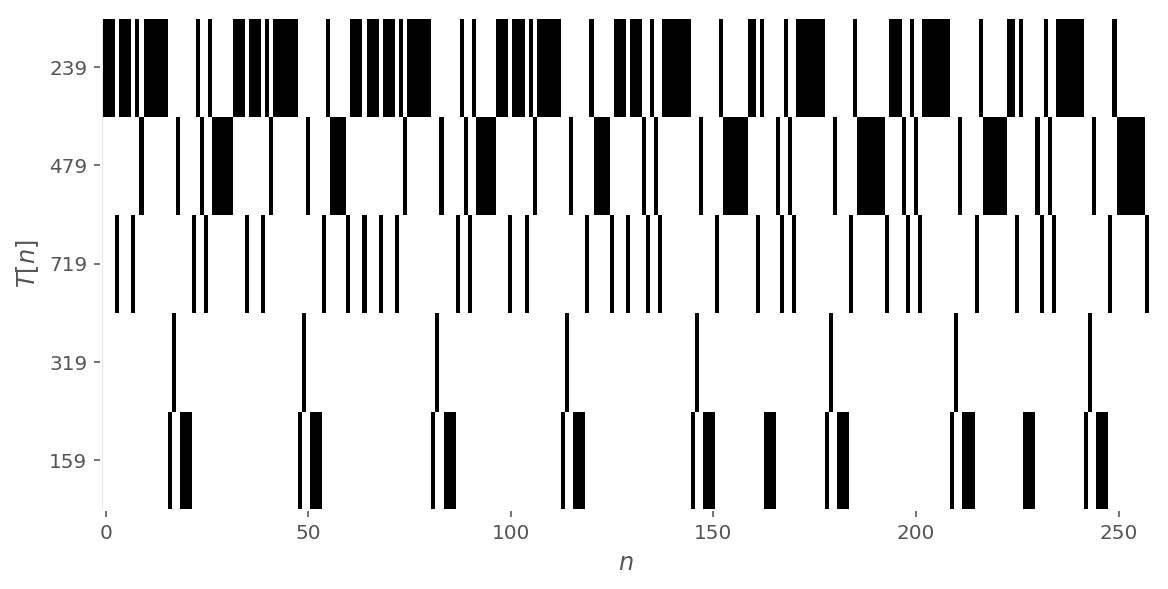

(398, 51) (398, 48) (398, 51) (398, 48)
1/1 [==============================] - 0s 56ms/step
[('loss', 2.3482785224914551), ('YT_loss', 0.75507718324661255), ('YP_loss', 1.5932012796401978), ('YT_acc', 0.74418610334396362), ('YP_acc', 0.42635664343833923)]


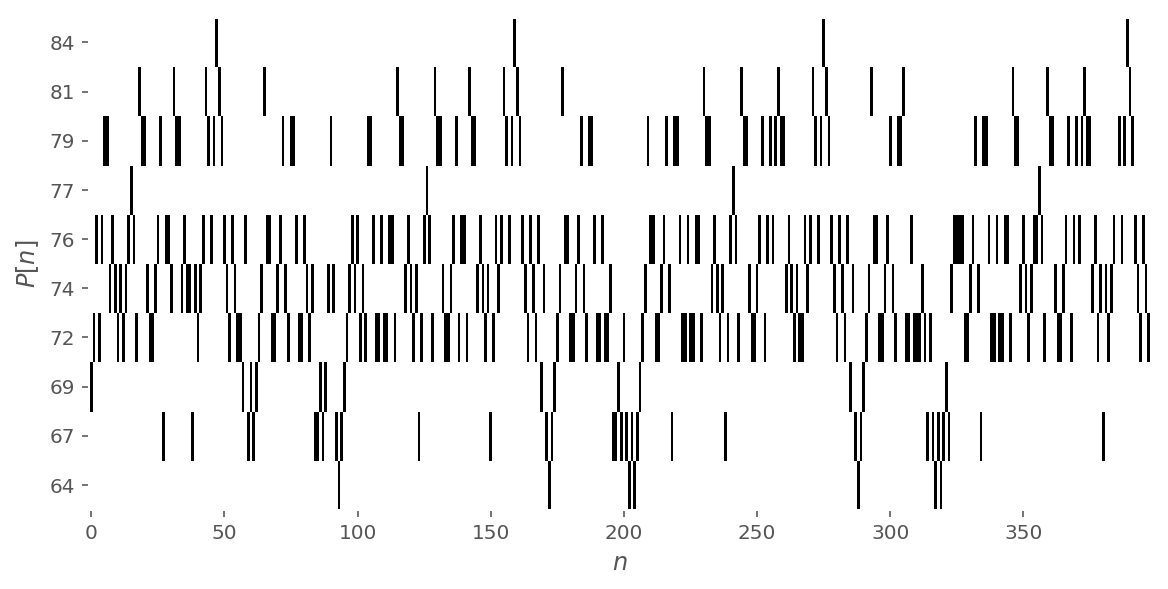

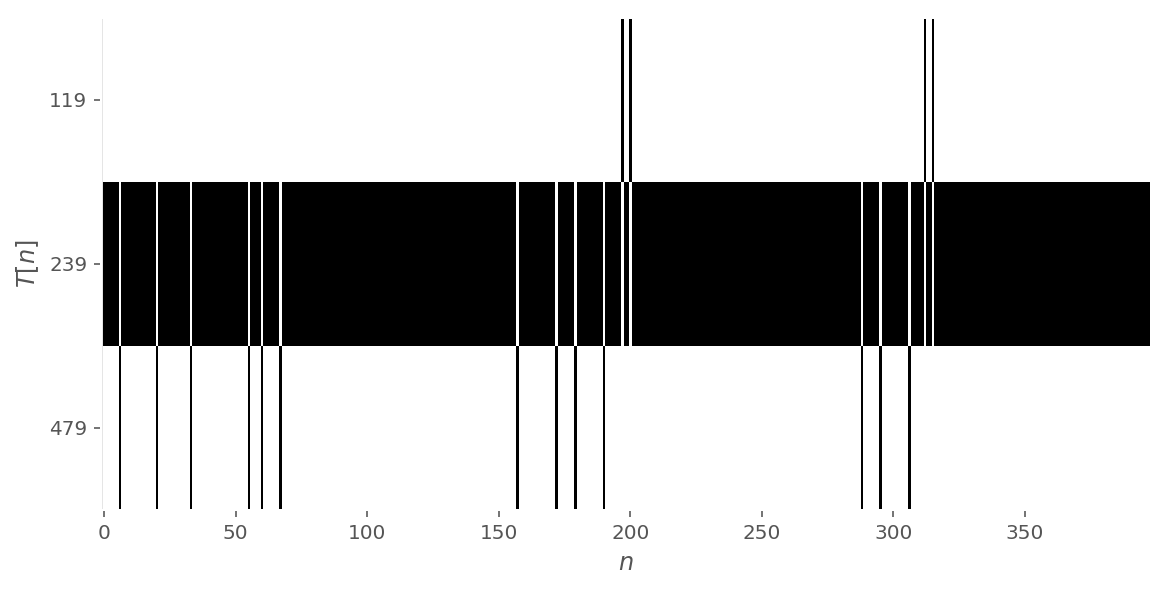

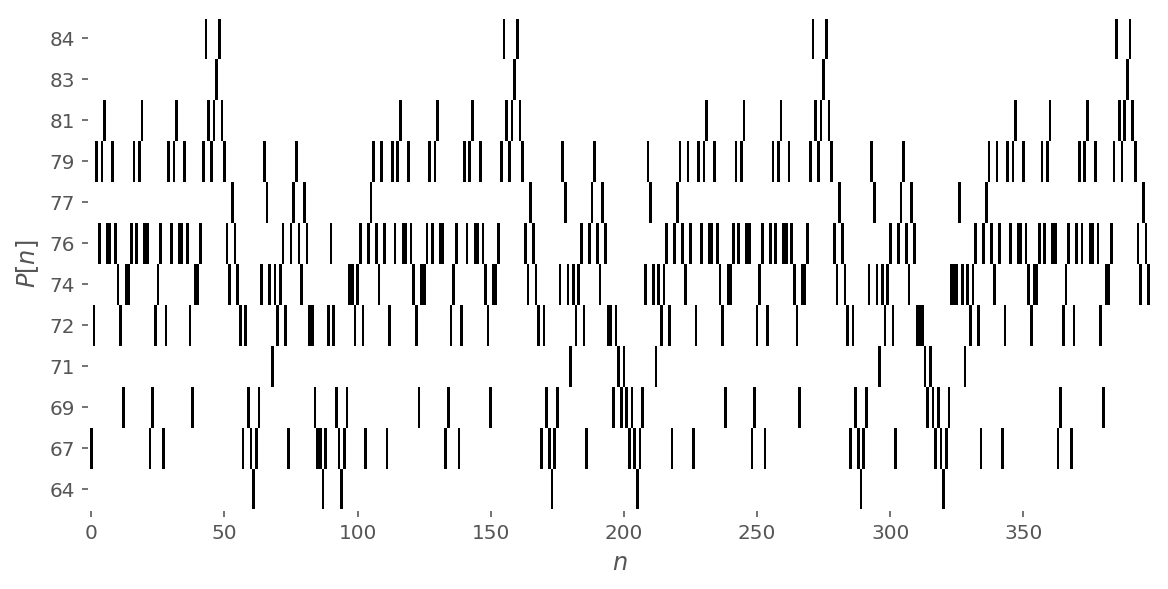

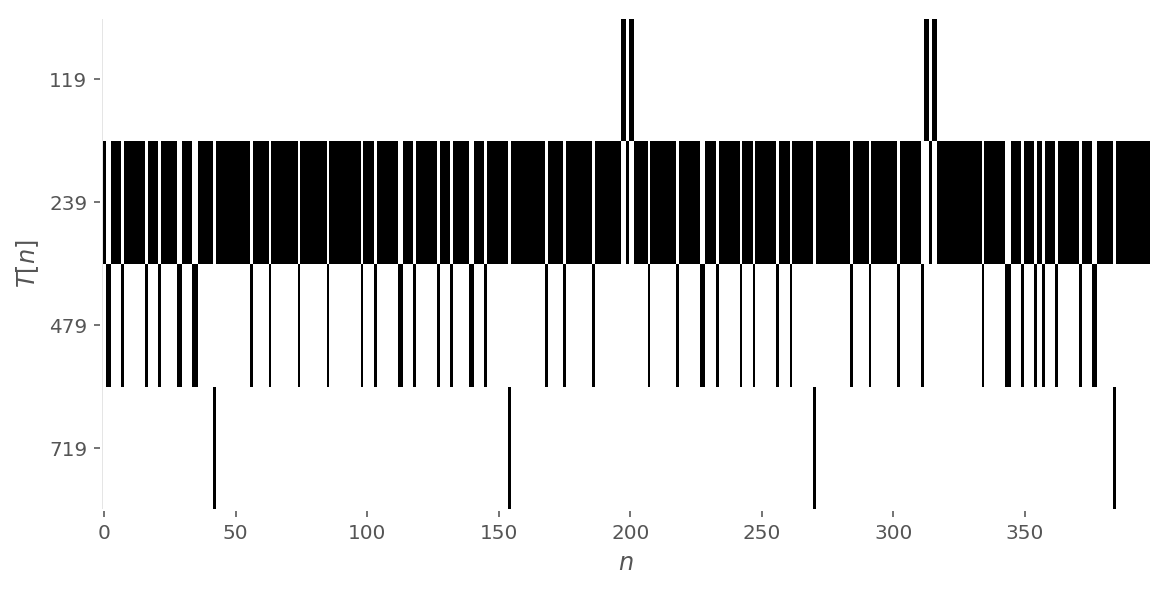

(398, 51) (398, 48) (398, 51) (398, 48)
1/1 [==============================] - 0s 66ms/step
[('loss', 2.0162248611450195), ('YT_loss', 0.41971522569656372), ('YP_loss', 1.596509575843811), ('YT_acc', 0.84170854091644287), ('YP_acc', 0.47487437725067139)]


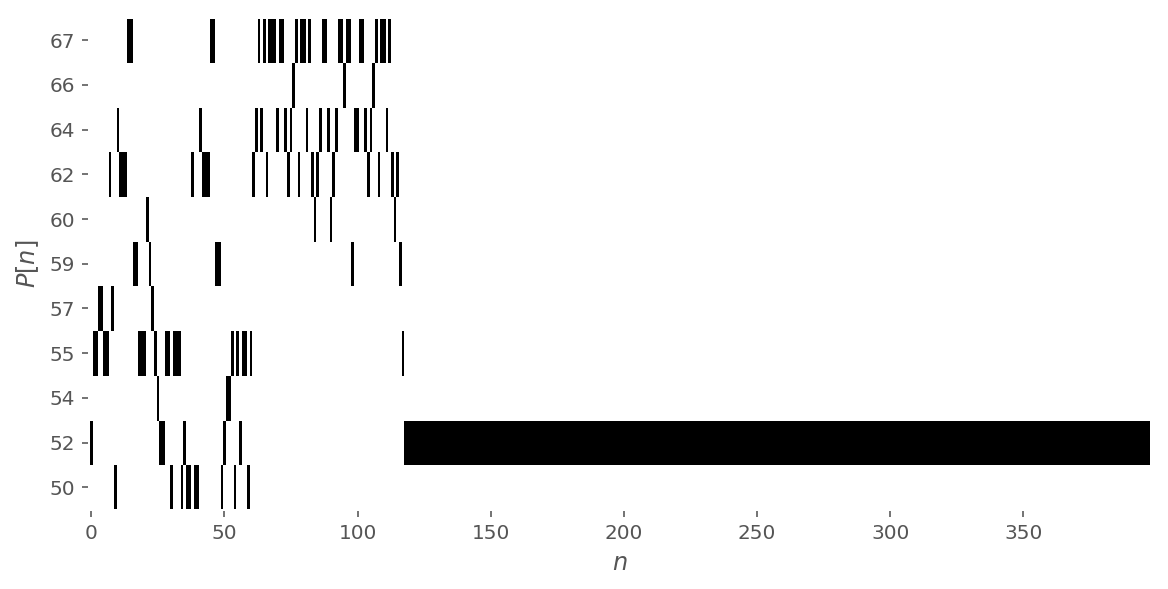

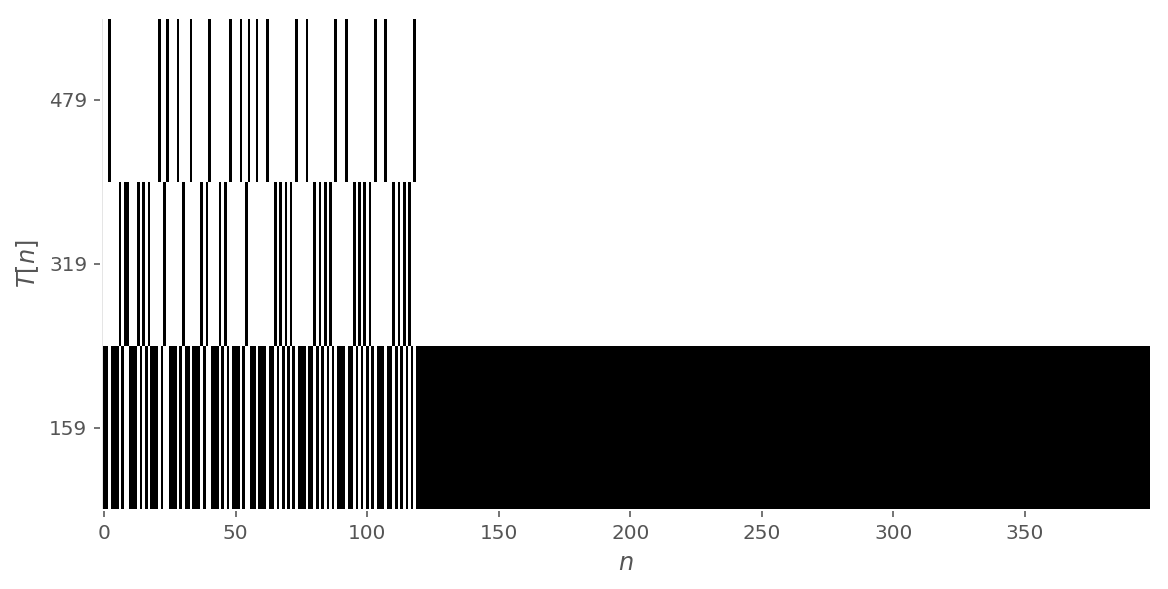

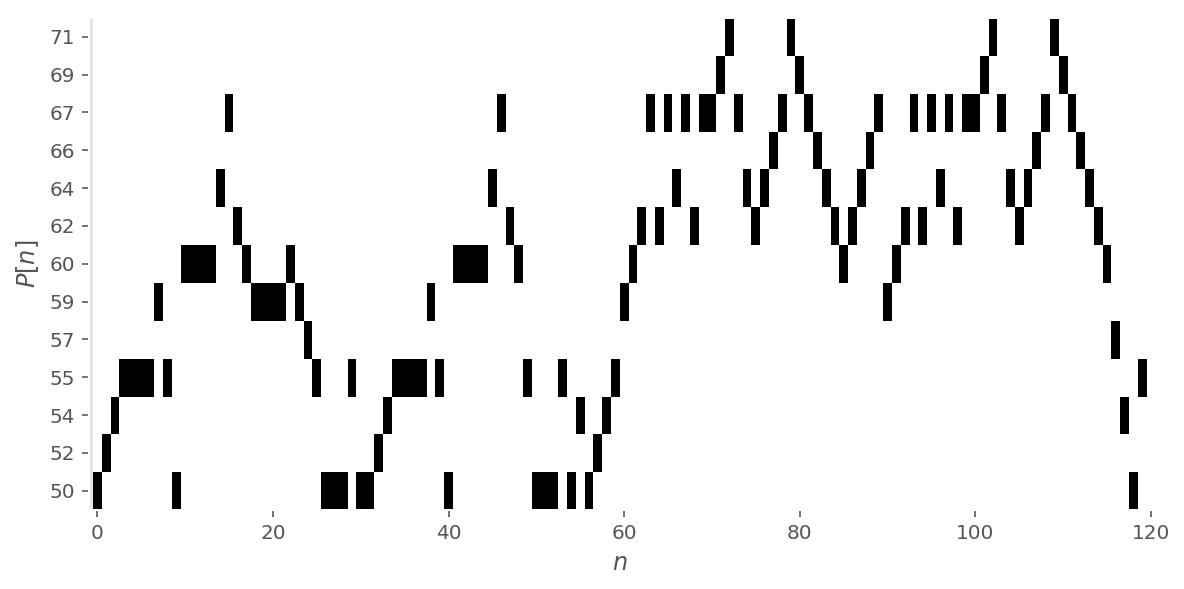

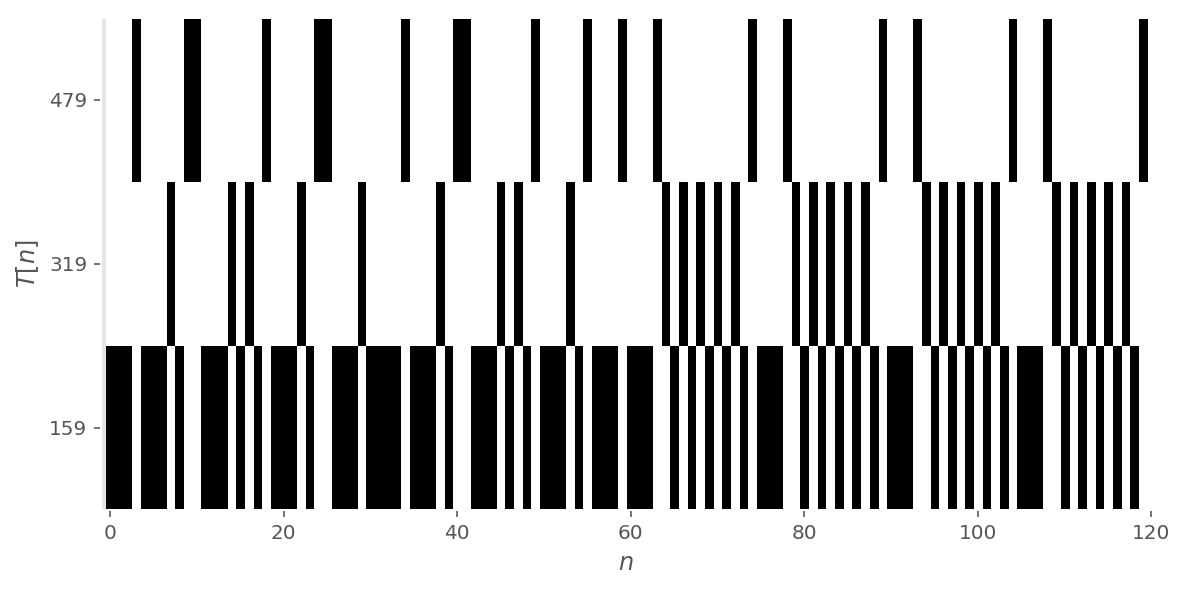

(398, 51) (398, 48) (398, 51) (398, 48)
1/1 [==============================] - 0s 63ms/step
[('loss', 2.0938441753387451), ('YT_loss', 0.38465213775634766), ('YP_loss', 1.7091920375823975), ('YT_acc', 0.86666655540466309), ('YP_acc', 0.375)]


In [75]:
pred = GRUmodel.predict({"XP": XP[rdm_melodies_idx], "XT": XT[rdm_melodies_idx]})
for i, v in enumerate(rdm_melodies_idx):
    
    one_hot_pred_p = np.zeros(pred[1][i].shape)
    one_hot_pred_t = np.zeros(pred[0][i].shape)
    
    for x in range(len(pred[0][i])):
        one_hot_pred_p[x][np.argmax(pred[1][i][x])] = 1
        one_hot_pred_t[x][np.argmax(pred[0][i][x])] = 1
    
    plotMelody(one_hot_pred_p, one_hot_pred_t, {"P": inv_p_dict, "T": inv_t_dict})
    plotMelody(XP[v], XT[v], {"P": inv_p_dict, "T": inv_t_dict})
    print(GRU_sample_acc(XP[v],XT[v],YP[v],YT[v]))

In [49]:
pred_3 = GRUmodel_w_o_output.predict({"XP": XP[rdm_melodies_idx], "XT": XT[rdm_melodies_idx]})

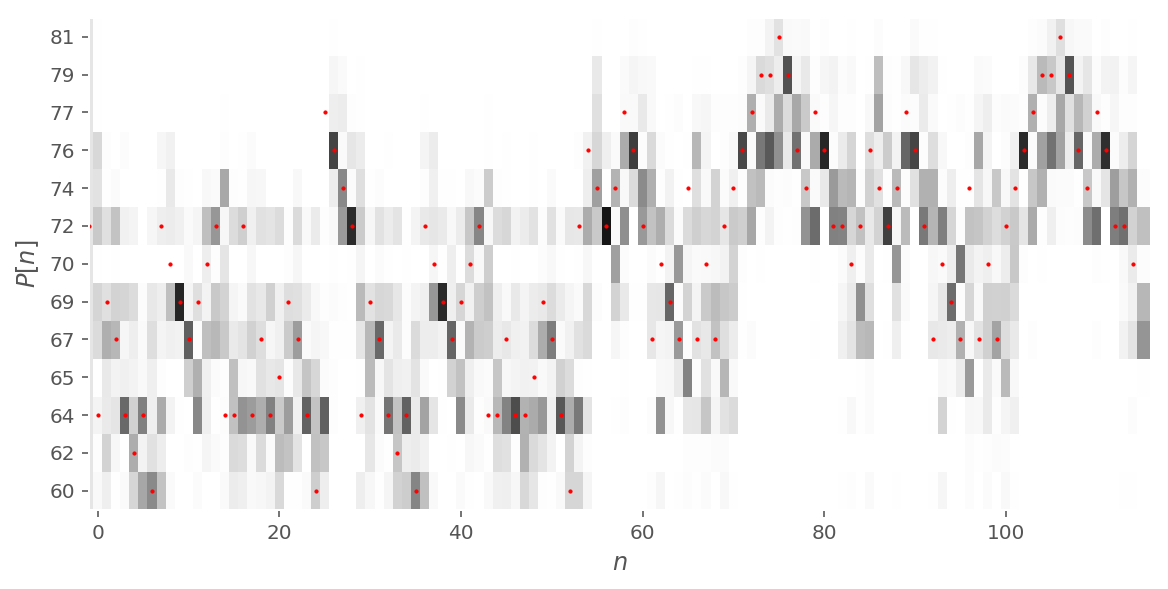

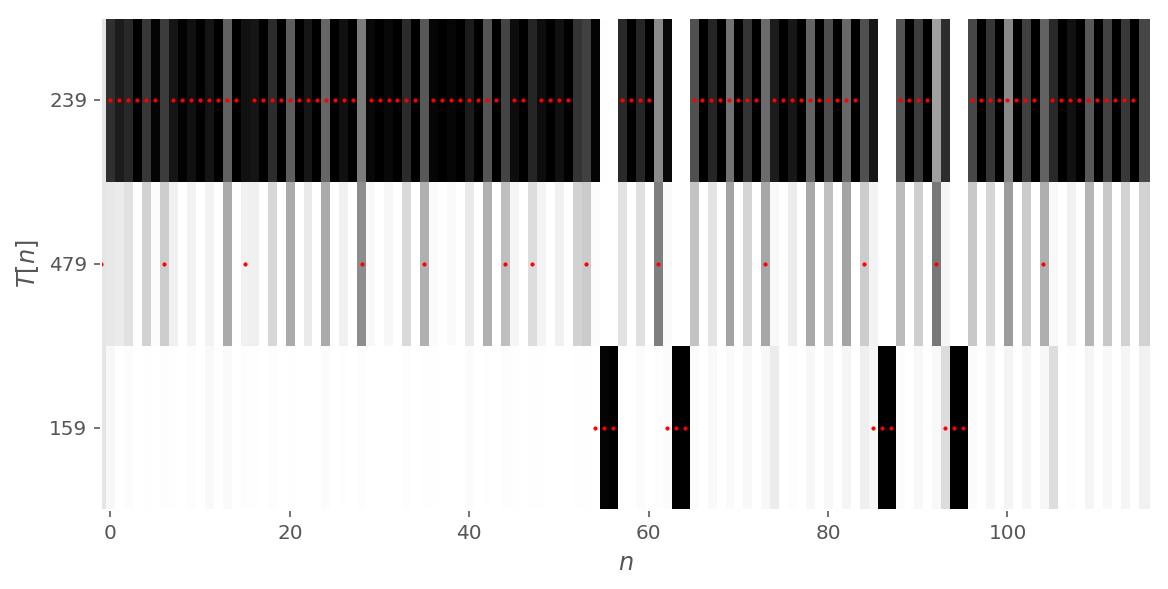

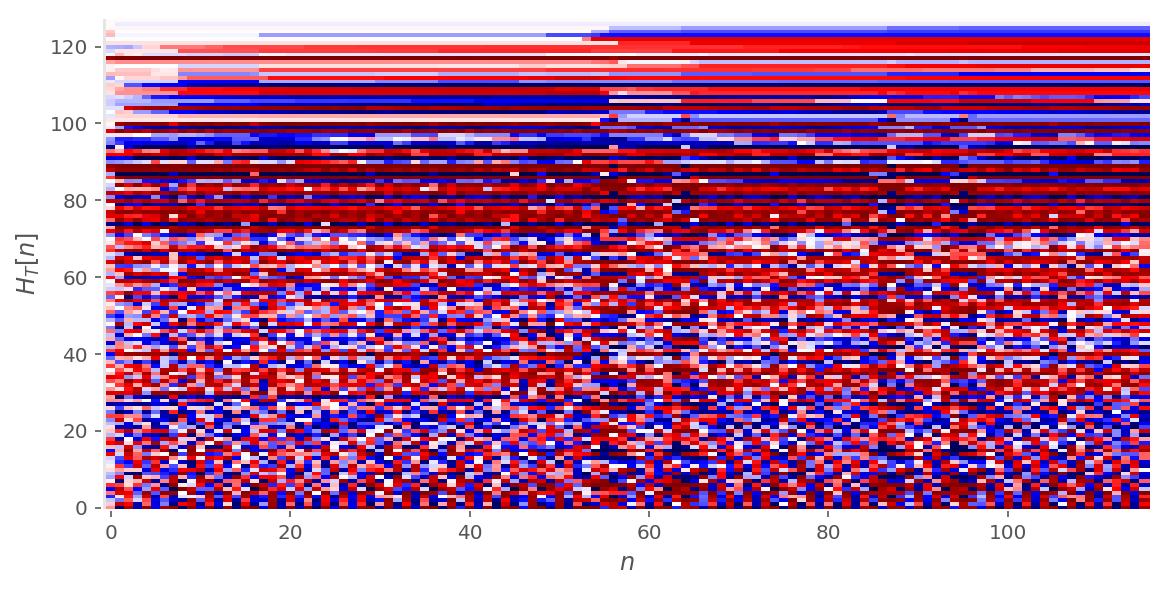

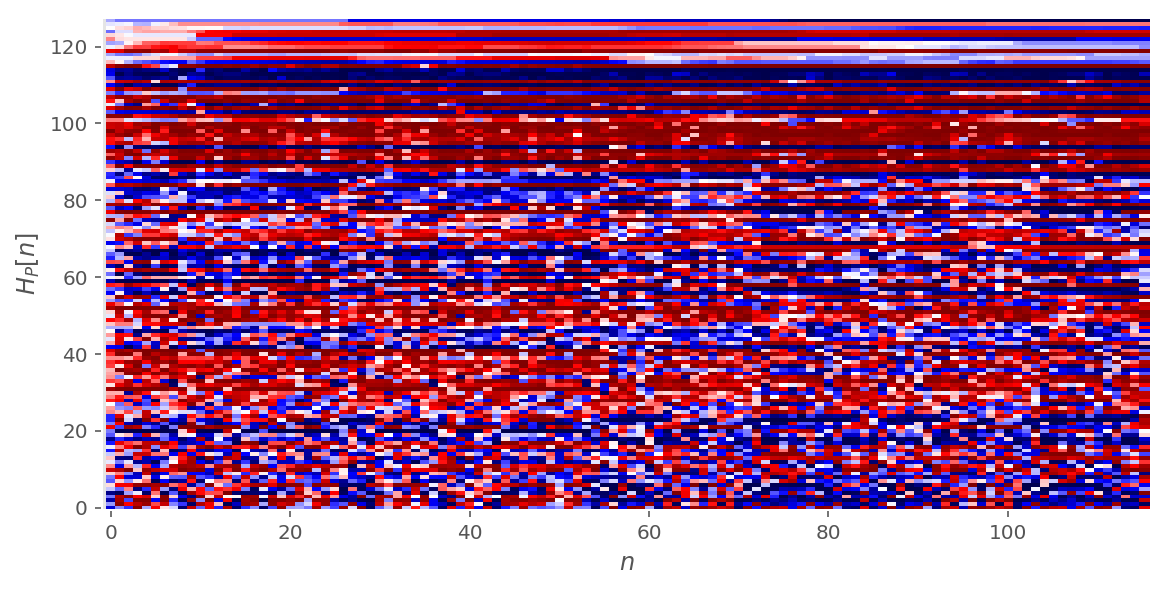

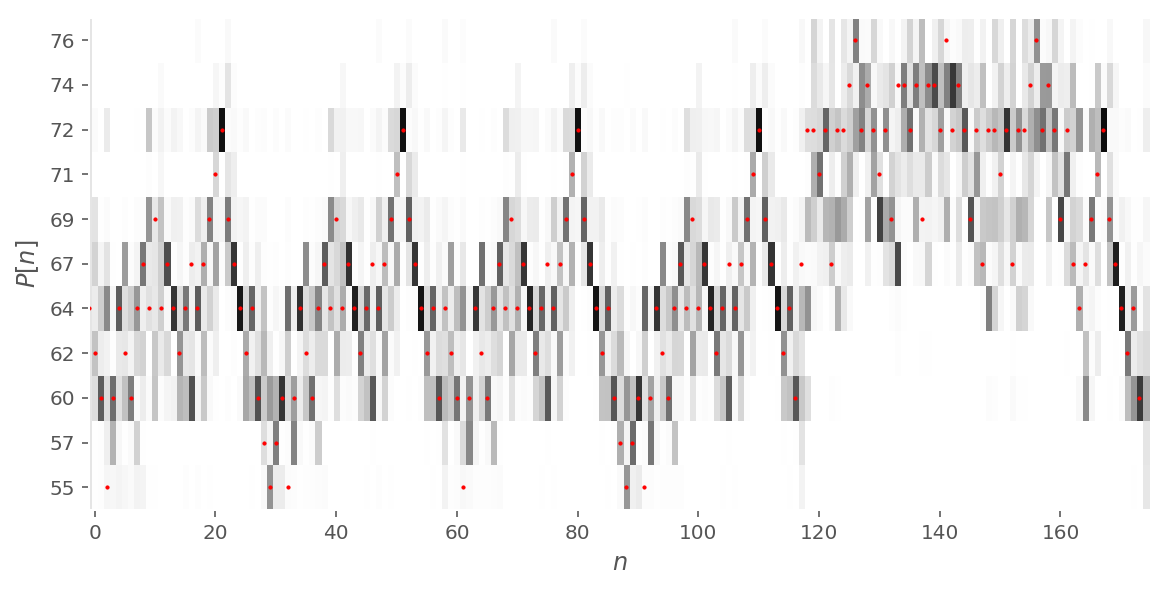

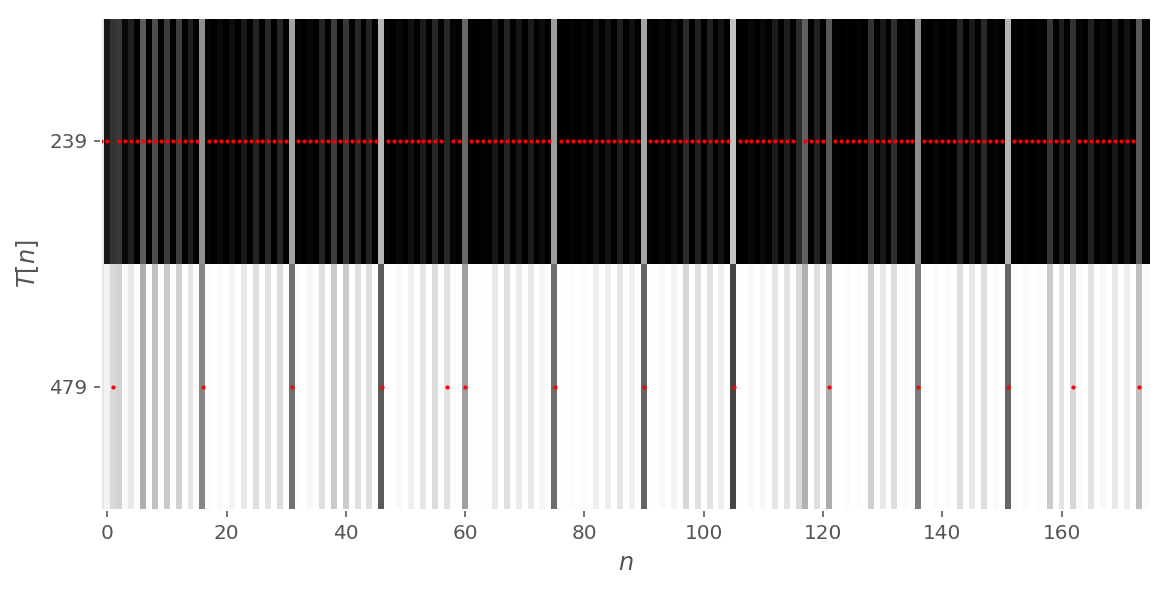

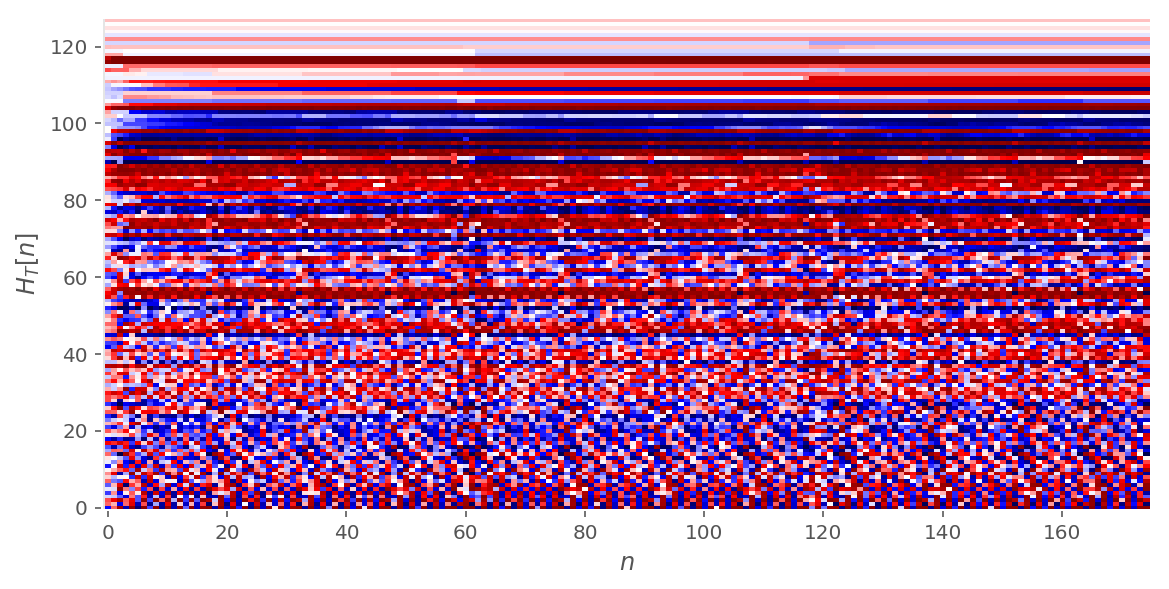

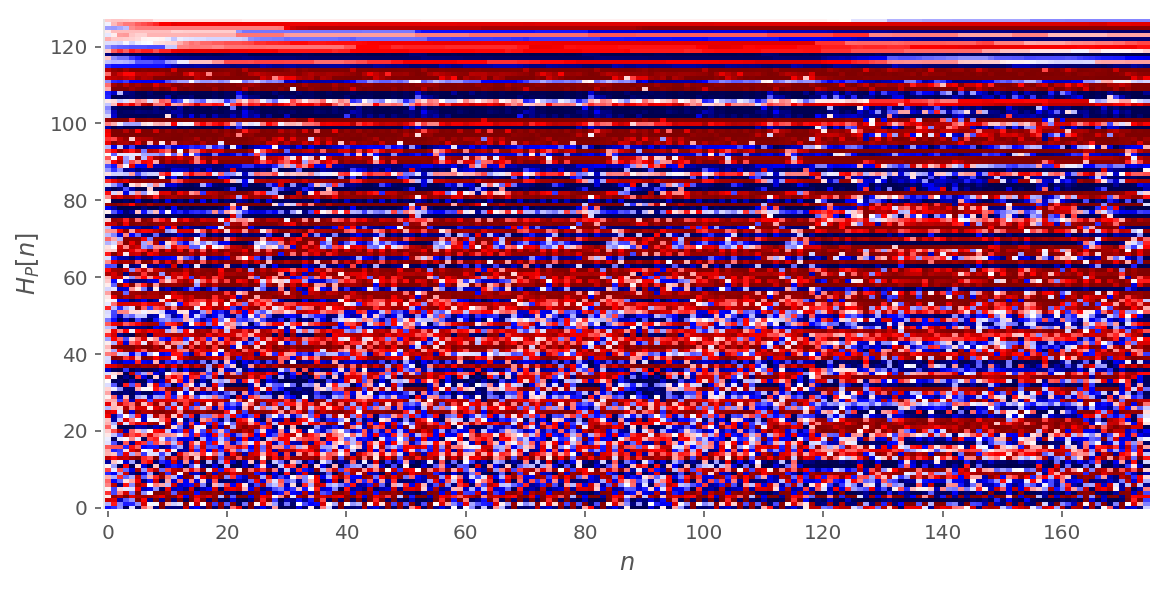

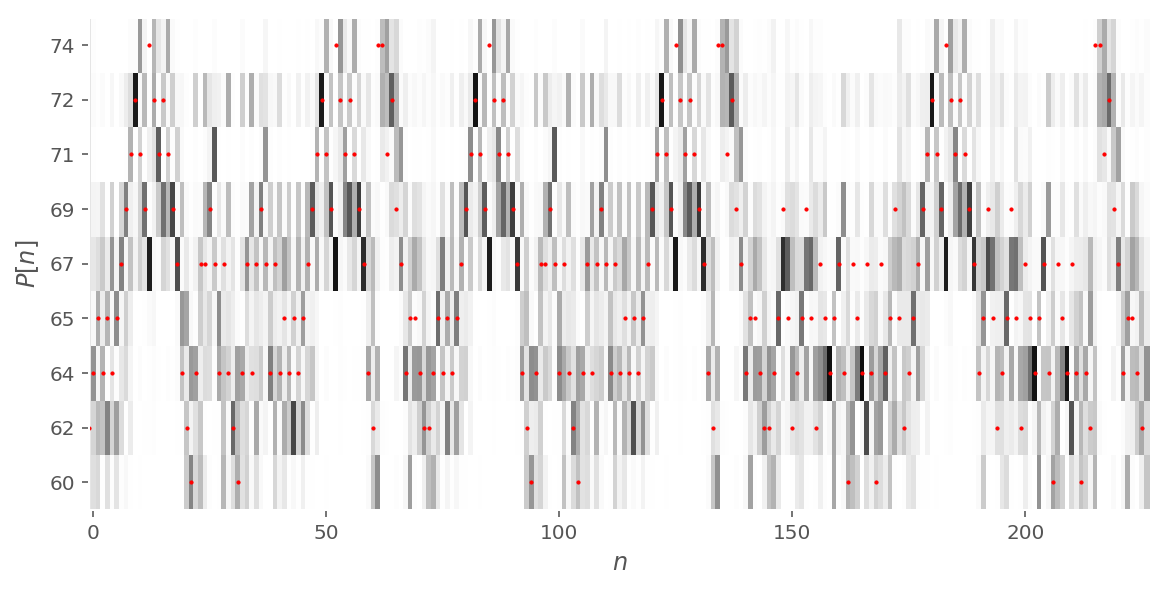

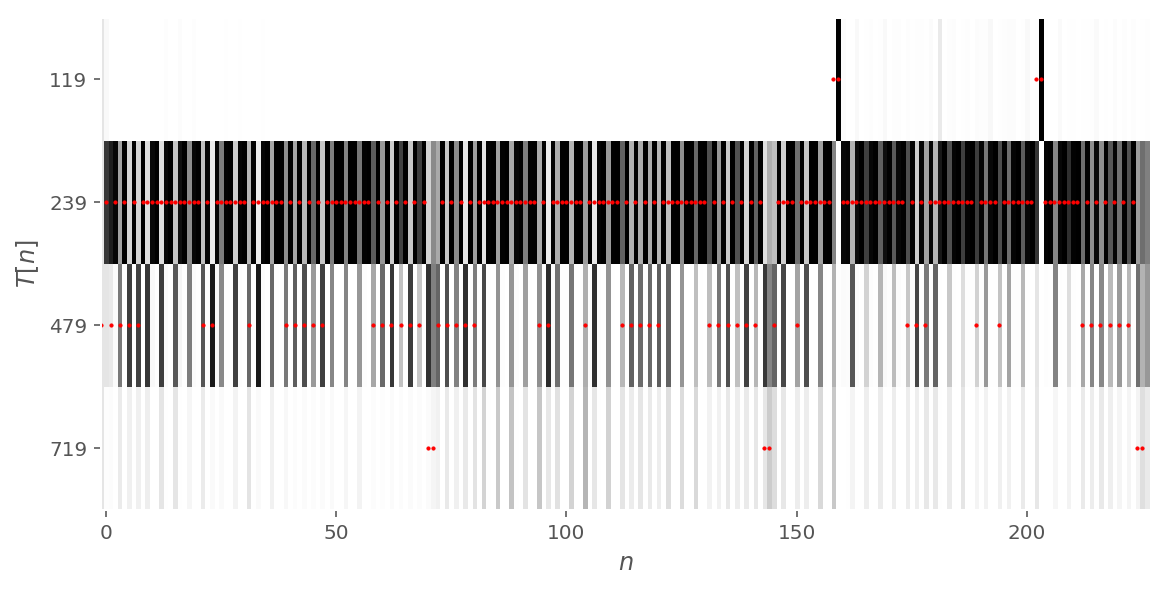

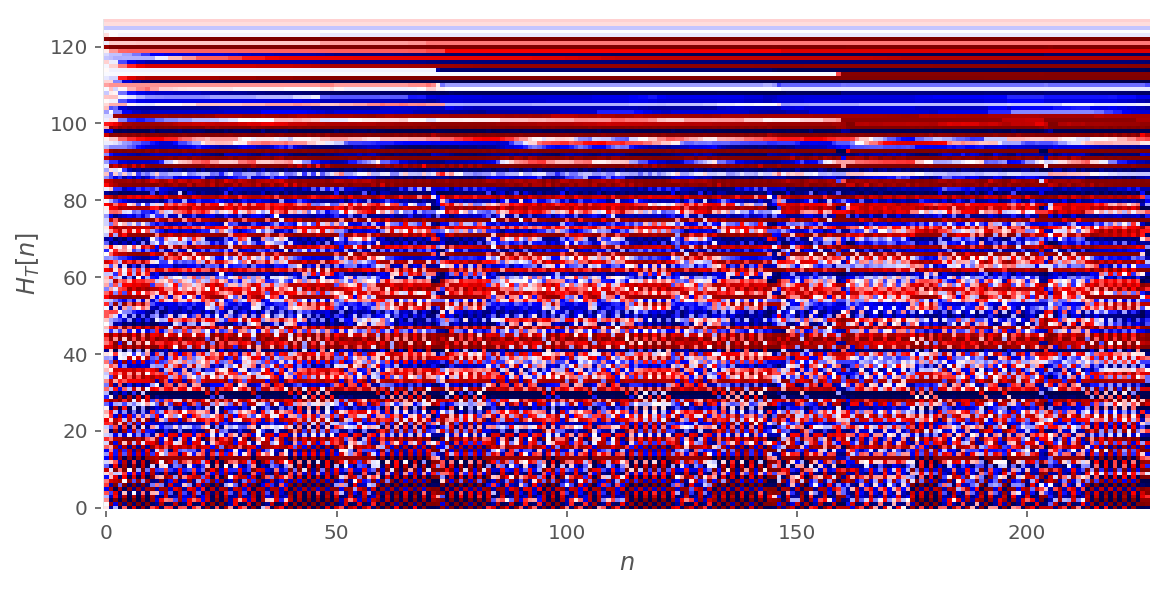

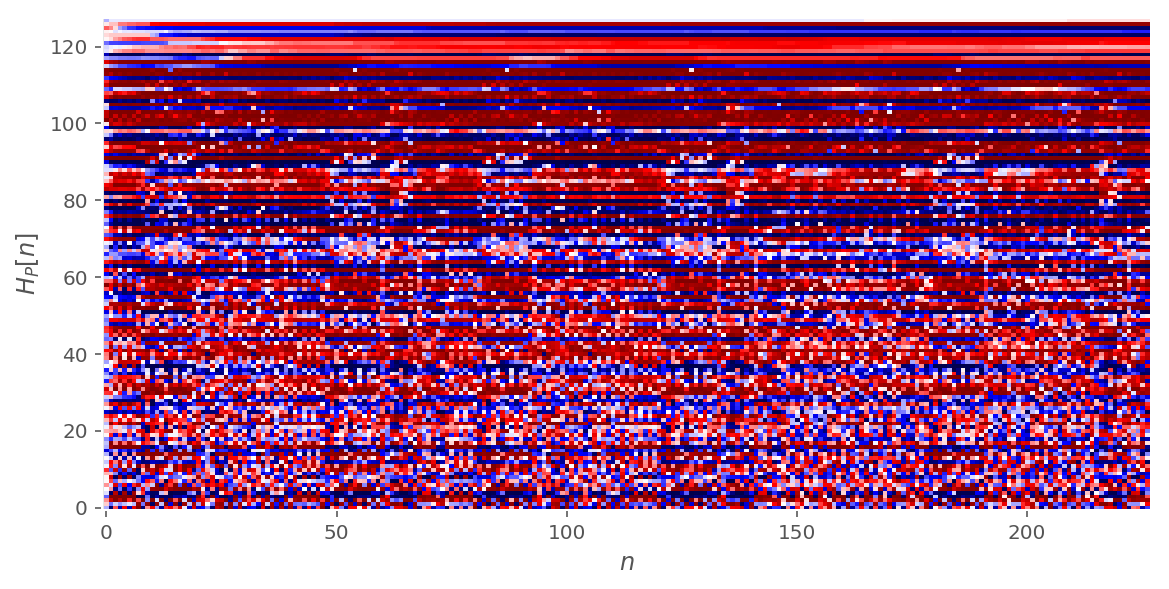

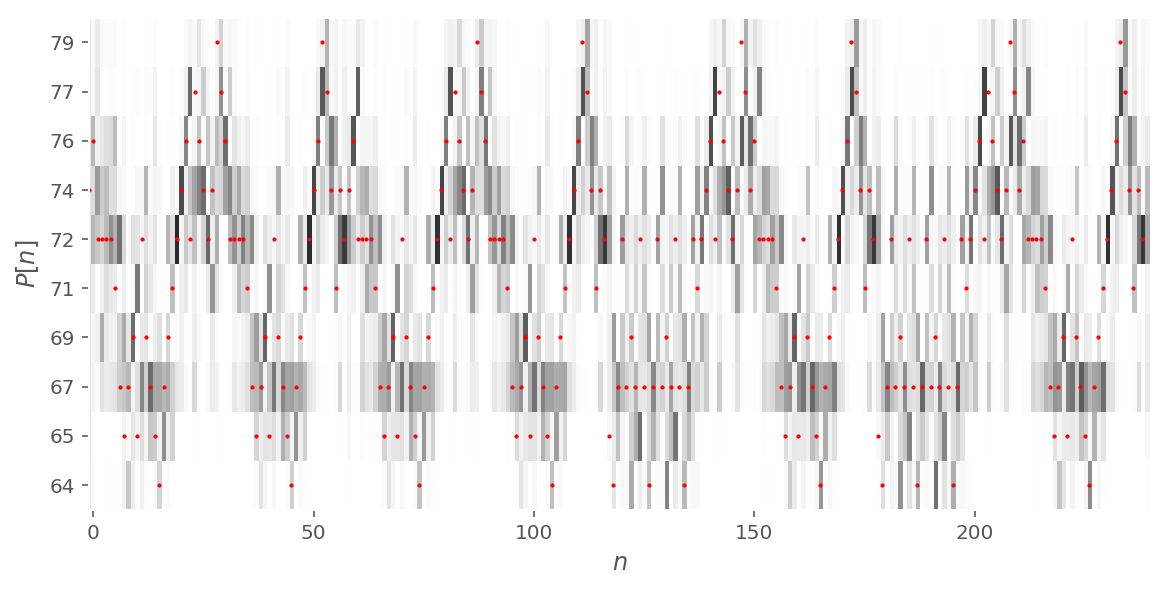

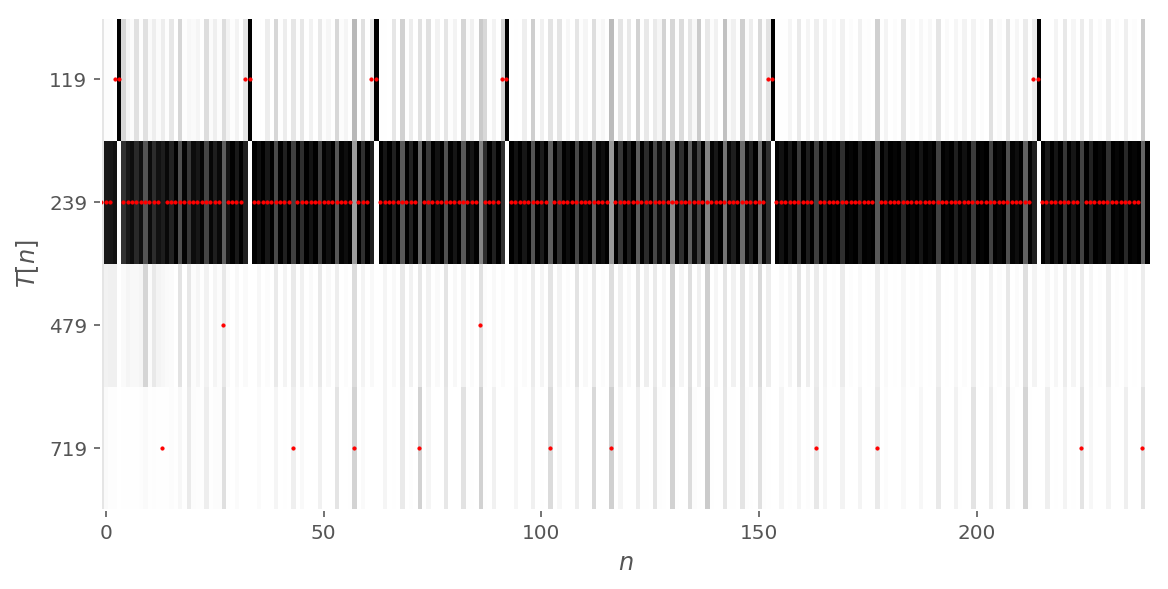

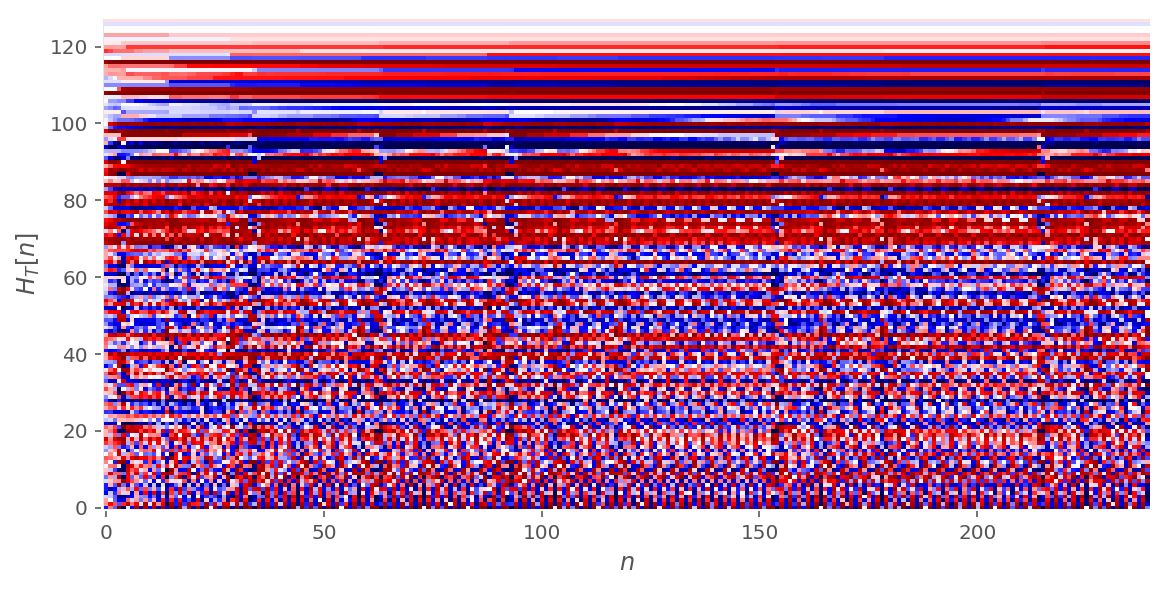

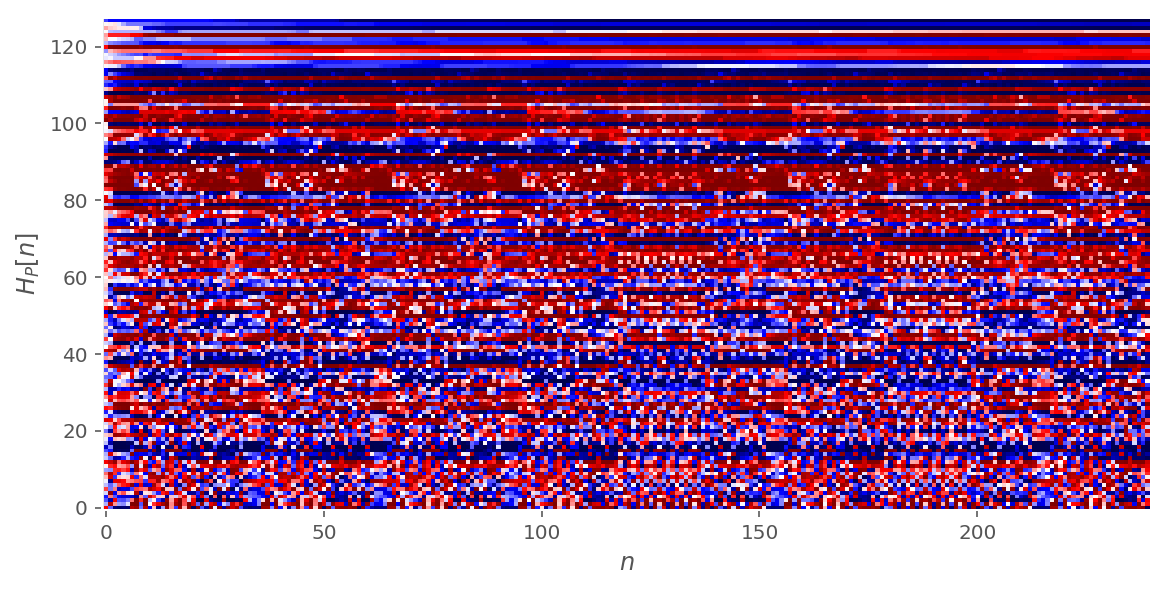

In [50]:
for i,v in enumerate(rdm_melodies_idx):
    plotMelody(XP[v], XT[v], {"P": inv_p_dict, "T": inv_t_dict},PrP=pred[1][i],PrT=pred[0][i],H_T=pred_3[0][i], H_P=pred_3[1][i])

In [51]:
def avg_abs_change(hidden_states_preds):
    bp = []
    for i in range(len(hidden_states_preds)):
        m = hidden_states_preds[i]
        mt = np.array(m).T
        diff = np.subtract(mt[:,:-1],mt[:,1:])
        mean = np.mean(np.abs(diff), axis = 1)
        bp.append(mean)
    return np.mean(bp, axis=0)

In [52]:
big_pred = GRUmodel_w_o_output.predict({"XP": XP,"XT": XT})
big_pred_1 = RNNmodel_w_o_output.predict({"XP": XP,"XT": XT})

In [53]:
gru_avg_abs_T = avg_abs_change(big_pred[0])
gru_avg_abs_P = avg_abs_change(big_pred[1])
rnn_avg_abs_T = avg_abs_change(big_pred_1[0])
rnn_avg_abs_P = avg_abs_change(big_pred_1[1])

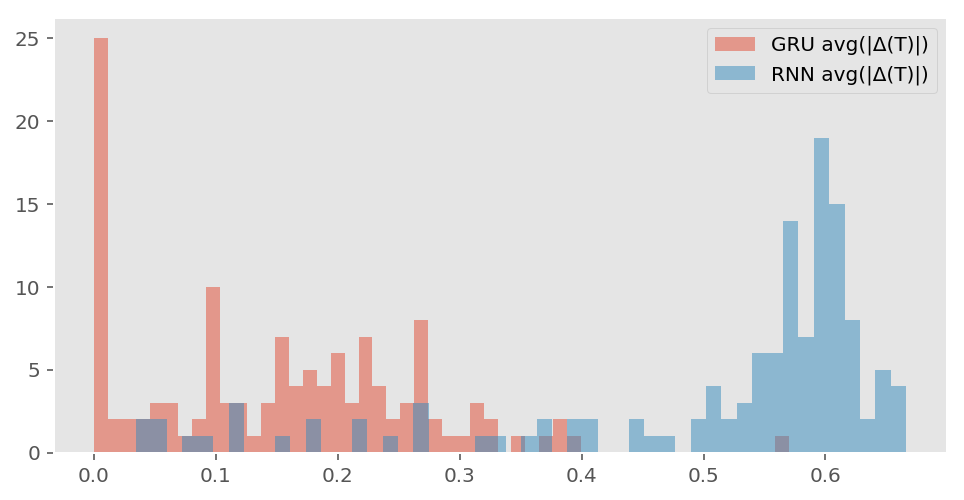

In [54]:
plt.hist(gru_avg_abs_T,bins = 50,alpha = 0.5, label="GRU avg(|Δ(T)|)")
plt.hist(rnn_avg_abs_T,bins = 50, alpha = 0.5, label="RNN avg(|Δ(T)|)")
plt.legend(loc = "upper right")
plt.show()

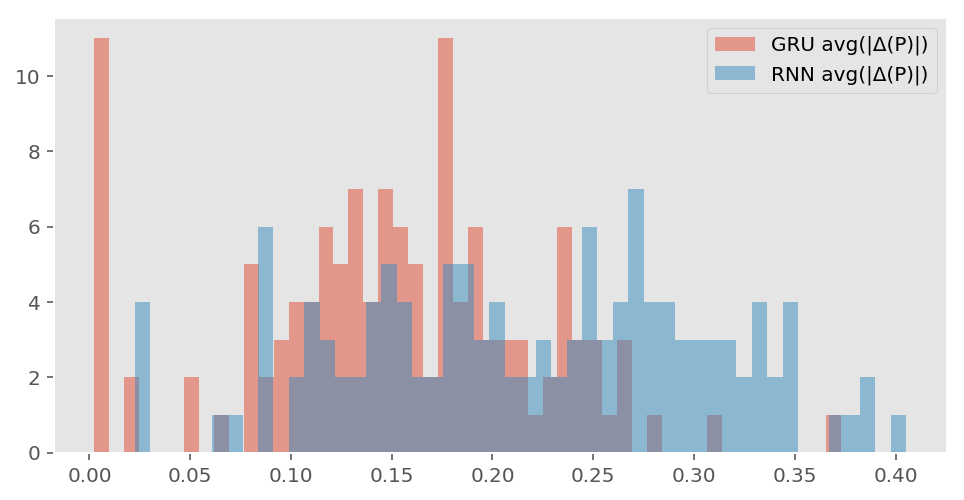

In [55]:
plt.hist(gru_avg_abs_P,bins = 50,alpha = 0.5, label="GRU avg(|Δ(P)|)")
plt.hist(rnn_avg_abs_P,bins = 50, alpha = 0.5, label="RNN avg(|Δ(P)|)")
plt.legend(loc = "upper right")
plt.show()

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: 


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [76]:
import random

In [77]:
def generate_melody(model,temperature, p=None, t=None):
    if p is None:
        p = random.randint(0,len(inv_p_dict))
    if t is None:
        t = random.randint(0,len(inv_t_dict))
    p1 = np_utils.to_categorical(p, len(inv_p_dict))
    t1 = np_utils.to_categorical(t, len(inv_t_dict))
    new_melod_p = p1.reshape((1,len(inv_p_dict)))
    new_melod_t = t1.reshape((1,len(inv_t_dict)))
    for i in range(2,maxlen-1):
        P_padded = pad_sequences(new_melod_p.reshape((1,-1,len(inv_p_dict))), maxlen=maxlen, padding='post')
        T_padded = pad_sequences(new_melod_t.reshape((1,-1,len(inv_t_dict))), maxlen=maxlen, padding='post')
        pr = model.predict({"XT": T_padded[0][:-1].reshape((1,-1,len(inv_t_dict))), "XP": P_padded[0][:-1].reshape((1,-1,len(inv_p_dict)))})
        sample_p = np.zeros(pr[1][0][0].shape)
        sample_t = np.zeros(pr[0][0][0].shape)
        sample_p[sample(pr[1][0][i],temperature=temperature)] = 1
        sample_t[sample(pr[0][0][i],temperature=temperature)] = 1
        new_melod_p = np.vstack((new_melod_p,sample_p.reshape((1,len(inv_p_dict)))))
        new_melod_t = np.vstack((new_melod_t,sample_t.reshape((1,len(inv_t_dict)))))
    return np.argmax(new_melod_p.reshape((-1,len(inv_p_dict))), axis = 1), np.argmax(new_melod_t.reshape((-1,len(inv_t_dict))), axis = 1) 

In [87]:
temperature_gru = [generate_melody(GRUmodel,x,10,40) for x in [0.5,1,1.5]]
temperature_rnn = [generate_melody(RNNmodel,x,10,40) for x in [0.5,1,1.5]]

In [88]:
print('difference in temperature GRU')
#music21.midi.translate.midiFilePathToStream('gru_10_40.mid').show('midi')
for i,mel in enumerate(temperature_gru):
    writeMIDI(mel[0], mel[1],{"P": inv_p_dict, "T": inv_t_dict}, "GRU_temp_"+str(i)+".mid")
    music21.midi.translate.midiFilePathToStream("GRU_temp_"+str(i)+".mid").show('midi')

difference in temperature GRU


In [89]:
print('difference in temperature RNN')
#music21.midi.translate.midiFilePathToStream('gru_10_40.mid').show('midi')
for i,mel in enumerate(temperature_rnn):
    writeMIDI(mel[0], mel[1],{"P": inv_p_dict, "T": inv_t_dict}, "RNN_temp_"+str(i)+".mid")
    music21.midi.translate.midiFilePathToStream("RNN_temp_"+str(i)+".mid").show('midi')

difference in temperature RNN


In [82]:
GRU_melodies = [generate_melody(GRUmodel, 1) for i in range(16)]
RNN_melodies = [generate_melody(RNNmodel, 1) for i in range(16)]

In [83]:
GRU_idx = np.random.choice(range(len(GRU_melodies)), size=4, replace=False)
RNN_idx = np.random.choice(range(len(RNN_melodies)), size=4, replace=False)

In [84]:
print('GRU')
#music21.midi.translate.midiFilePathToStream('gru_10_40.mid').show('midi')
for i,idx in enumerate(GRU_idx):
    writeMIDI(GRU_melodies[idx][0], GRU_melodies[idx][1],{"P": inv_p_dict, "T": inv_t_dict}, "GRU_"+str(i)+".mid")
    music21.midi.translate.midiFilePathToStream("GRU_"+str(i)+".mid").show('midi')

GRU


In [85]:
print('RNN')
#music21.midi.translate.midiFilePathToStream('gru_10_40.mid').show('midi')
for i,idx in enumerate(RNN_idx):
    writeMIDI(RNN_melodies[idx][0], RNN_melodies[idx][1],{"P": inv_p_dict, "T": inv_t_dict}, "RNN_"+str(i)+".mid")
    music21.midi.translate.midiFilePathToStream("RNN_"+str(i)+".mid").show('midi')

RNN


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: 
The smaller the sampling temperature, the higher the probabitity of taking the "most probable" pitch/tick. We can hear that with temperature 0.5 it is a easy melodie going up and down most of the time since it is the most natural choice. With temperature 1.5 the result is more random in terms of melody

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: 
It seems to sounds different but we are not really able to quantify what it is. The GRU just sounds better for us maybe more fluid. RNN sounds like GRU with a higher temperature sampling.
